XGBoost Classification - 'real-world' example: UCI Skin Segmentation dataset

GP ERM versus STP nu = 3 ERM

https://archive.ics.uci.edu/ml/datasets/Skin+Segmentation

In [ ]:
pip install pyGPGO


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 14.4 MB/s 
     |████████████████████████████████| 872 kB 51.0 MB/s 
  Created wheel for pyGPGO: filename=pyGPGO-0.5.1-py3-none-any.whl size=19880 sha256=965b0bf70d11b363b211746ffa00656ba4fad3735c275198baabc938ffcf00f9
  Stored in directory: /root/.cache/pip/wheels/c8/5d/0b/2160114e2f1b87791c51b66cf07f89831dbb6f49167950316f
  Created wheel for Theano-PyMC: filename=Theano_PyMC-1.1.2-py3-none-any.whl size=1529964 sha256=da8206c749c41c69186eae9b4d9e787943fce7f4fe5dd49e4626be0e3b6669c0
  Stored in directory: /root/.cache/pip/wheels/f3/af/8c/5dd7553522d74c52a7813806fc7ee1a9caa20a3f7c8fd850d5
Successfully built pyGPGO Theano-PyMC


In [ ]:
# Load some default Python modules:

import numpy as np
import scipy as sp
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.pyplot import rc
rc('text', usetex=False)

from collections import OrderedDict
from numpy.linalg import slogdet
from scipy.linalg import inv
from scipy.optimize import minimize
from scipy.special import gamma
from scipy.stats import norm, t
from joblib import Parallel, delayed

from pyGPGO.logger import EventLogger
from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.surrogates.tStudentProcess import tStudentProcess
from pyGPGO.surrogates.tStudentProcess import logpdf
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential, matern32, matern52
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error

import xgboost as xgb
from xgboost import XGBClassifier

import warnings
import random
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)


In [ ]:
def ReadData():
    #Data in format [B G R Label] from
    data = np.genfromtxt('/content/sample_data/Skin_NonSkin.txt', dtype=np.int32)

    labels = data[:,3]
    data = data[:,0:3]

    return data, labels

data, labels = ReadData()

X = data
y = labels


In [ ]:
### Bayesian Optimisation - inputs:

obj_func = 'XGBoost'
n_test = 500 # test points
eps = 1e-08
df = 3 # nu

util_gp = 'RegretMinimized'
util_stp = 'tRegretMinimized'
n_init = 5 # random initialisations

test_perc = 0.1
train_perc = 1 - test_perc
n_est = 3

obj_classifier = 'binary:logistic'
cov_func = squaredExponential()
hyperOpt = True


In [ ]:
### Objective function:

if obj_func == 'XGBoost':
    
    # Constraints:
    param_lb_alpha = 0
    param_ub_alpha = 10
    
    param_lb_gamma = 0
    param_ub_gamma = 10
    
    param_lb_max_depth = 5
    param_ub_max_depth = 15
    
    param_lb_min_child_weight = 1
    param_ub_min_child_weight = 20
    
    param_lb_subsample = .5
    param_ub_subsample = 1
    
    param_lb_colsample = .1
    param_ub_colsample = 1
    
    # 6-D inputs' parameter bounds:
    param = { 'alpha':  ('cont', (param_lb_alpha, param_ub_alpha)),
         'gamma':  ('cont', (param_lb_gamma, param_ub_gamma)),     
         'max_depth':  ('int', (param_lb_max_depth, param_ub_max_depth)),
         'subsample':  ('cont', (param_lb_subsample, param_ub_subsample)),
          'min_child_weight':  ('int', (param_lb_min_child_weight, param_ub_min_child_weight)),
            'colsample': ('cont', (param_lb_colsample, param_ub_colsample))
        }
       
    # True y bounds:
    y_global_orig = 1
    dim = 6
    
    max_iter = 30 

In [ ]:
n_start_AcqFunc = dim * 10
inverse = 1


In [ ]:
### Cumulative Regret Calculator:

def min_max_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list


In [ ]:
### Set-seeds:

run_num_1 = 1
run_num_2 = 2
run_num_3 = 3
run_num_4 = 4
run_num_5 = 5
run_num_6 = 6
run_num_7 = 7
run_num_8 = 8
run_num_9 = 9
run_num_10 = 10
run_num_11 = 11
run_num_12 = 12
run_num_13 = 13
run_num_14 = 14
run_num_15 = 15
run_num_16 = 16
run_num_17 = 17
run_num_18 = 18
run_num_19 = 19
run_num_20 = 20


In [ ]:
### Add new acquisition functions

# Inherits from class Acquisition()

class Acquisition_new(Acquisition):    
    def __init__(self, mode, eps=1e-06, **params):
        
        self.params = params
        self.eps = eps

        mode_dict = {
            'RegretMinimized': self.RegretMinimized,
            'tRegretMinimized': self.tRegretMinimized
        }

        self.f = mode_dict[mode]
   
    def RegretMinimized(self, tau, mean, std):
            
        z = (mean - y_global_orig - self.eps) / (std + self.eps)
        return z * (std + self.eps) * norm.cdf(z) + (std + self.eps) * norm.pdf(z)[0]
    
    def tRegretMinimized(self, tau, mean, std, nu=3.0):
        
        gamma = (mean - y_global_orig - self.eps) / (std + self.eps)
        return gamma * (std + self.eps) * t.cdf(gamma, df=nu) + (std + self.eps) * (nu + gamma ** 2)/(nu - 1) * t.pdf(gamma, df=nu)
    
    def eval(self, y_global_orig, mean, std):
    
        return self.f(y_global_orig, mean, std, **self.params)
        
    def t_eval(self, y_global_orig, mean, std, nu=df):
    
        return self.f(y_global_orig, mean, std, nu=df, **self.params)
        

In [ ]:
## GPGO_multi: Gaussian

n_start = n_start_AcqFunc

class GPGO_multi(GPGO):

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header ='Eval. \t Proposed point                                                            \t Current           \t Best'
        self.template = '{:3}\t {}\t {:3}\t {:3}\t '
 
    def acqfuncApprox(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        f = self.A.eval(self.tau, new_mean, new_std)

        return -f
   
    def _optimizeAcq(self, method='L-BFGS-B'):
        
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        f_best_min = min(f_best)

        self.x_best = x_best
        self.f_best = f_best
        self.f_best_min = f_best_min
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr        
        self.history.append(self.f_best_min)

    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        min_acqfunc = str(self.f_best_min)
        if float(curr_eval) >= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            min_acqfunc = BOLD + OKGREEN + min_acqfunc + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best))
        
    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [ ]:
## GPGO_multi_STP: Student's-t

class GPGO_multi_STP(GPGO):

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header ='Eval. \t Proposed point                                                            \t Current           \t Best'
        self.template = '{:3}\t {}\t {:3}\t {:3}'
 
    def acqfuncApprox(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        f = self.A.t_eval(self.tau, new_mean, new_std)

        return -f
   
    def _optimizeAcq(self, method='L-BFGS-B'):
        
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        f_best_min = min(f_best)

        self.x_best = x_best
        self.f_best = f_best
        self.f_best_min = f_best_min
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr        
        self.history.append(self.f_best_min)

    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        min_acqfunc = str(self.f_best_min)
        if float(curr_eval) >= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            min_acqfunc = BOLD + OKGREEN + min_acqfunc + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best))
        
    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [ ]:
### Bayesian optimisation runs (x20): 'gp' Acquisition Function run number = 1

np.random.seed(run_num_1)
surrogate_gp_1 = GaussianProcess(cov_func, optimize=hyperOpt)

X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=test_perc, random_state=run_num_1)

def f_syn_polarity1(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, 
                       min_child_weight=min_child_weight,colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_1, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train1, y=y_train1).mean())
    return  score

gp_1 = GPGO_multi(surrogate_gp_1, Acquisition_new(util_gp), f_syn_polarity1, param, n_jobs = -1) # define BayesOpt
gp_1.run(max_iter = max_iter, init_evals = n_init) # run


Eval. 	 Proposed point                                                            	 Current           	 Best
init	 [ 4.17022005  7.20324493 14.          0.65116629 16.          0.31248008]	 0.8046299919555899	 0.9918296241194998	 
init	 [ 3.96580727  3.87910741 11.          0.96776954  6.          0.71669755]	 0.9918296241194998	 0.9918296241194998	 
init	 [ 2.0445225   8.78117436  7.          0.95698101 10.          0.48762871]	 0.8056864272469906	 0.9918296241194998	 
init	 [ 9.39127789  7.78389236 14.          0.98413079  2.          0.87851823]	 0.9912809996993375	 0.9918296241194998	 
init	 [8.29146907 8.29603359 8.         0.58491521 9.         0.18851215]	 0.8048022933180651	 0.9918296241194998	 
1  	 [ 3.92596249  4.64400208 11.          0.99854512  5.77366095  0.69483758]	 0.9916936028034344	 0.9918296241194998	 
2	 [ 3.53129651  4.09014453 10.99991538  1.          5.38114872  0.72955346]	 0.9959646511383987	 0.9959646511383987	 
3  	 [ 3.52075452  4.25541216 10.5499942   1.  

In [ ]:
### Bayesian optimisation runs (x20): 'gp' Acquisition Function run number = 2

np.random.seed(run_num_2)
surrogate_gp_2 = GaussianProcess(cov_func, optimize=hyperOpt)

X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=test_perc, random_state=run_num_2)

def f_syn_polarity2(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_2, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train2, y=y_train2).mean())
    return  score

gp_2 = GPGO_multi(surrogate_gp_2, Acquisition_new(util_gp), f_syn_polarity2, param, n_jobs = -1) # define BayesOpt
gp_2.run(max_iter = max_iter, init_evals = n_init) # run


Eval. 	 Proposed point                                                            	 Current           	 Best
init	 [ 4.35994902  0.25926232 11.          0.97386531 12.          0.47833102]	 0.8594066752758843	 0.9809431387412995	 
init	 [ 3.30334821  2.04648634 10.          0.55997527  6.          0.71472339]	 0.9809431387412995	 0.9809431387412995	 
init	 [ 4.9856117   5.86796978  8.          0.89266757 11.          0.59158659]	 0.8587265533800185	 0.9809431387412995	 
init	 [ 4.07307832  1.76984624 13.          0.75262305  7.          0.35908193]	 0.8588625827136147	 0.9809431387412995	 
init	 [ 1.16193318  1.81727038  9.          0.79837265 19.          0.29965165]	 0.859538164220113	 0.9809431387412995	 
1  	 [ 3.53766533  1.9622651  10.91324837  0.61861979  6.30441549  0.60645965]	 0.8584318407683845	 0.9809431387412995	 
2  	 [ 3.52823406  1.77590302 10.03081329  0.62020011  6.71937486  0.66433717]	 0.8589079234949326	 0.9809431387412995	 
3  	 [ 2.80430136  2.13596124 10.3336806

In [ ]:
### Bayesian optimisation runs (x20): 'gp' Acquisition Function run number = 3

np.random.seed(run_num_3)
surrogate_gp_3 = GaussianProcess(cov_func, optimize=hyperOpt)

X_train3, X_test3, y_train3, y_test3 = train_test_split(X, y, test_size=test_perc, random_state=run_num_3)

def f_syn_polarity3(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_3, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train3, y=y_train3).mean())
    return  score

gp_3 = GPGO_multi(surrogate_gp_3, Acquisition_new(util_gp), f_syn_polarity3, param, n_jobs = -1) # define BayesOpt
gp_3.run(max_iter = max_iter, init_evals = n_init) # run


Eval. 	 Proposed point                                                            	 Current           	 Best
init	 [ 5.50797903  7.08147823 13.          0.56066429 11.          0.11687321]	 0.8998871626077205	 0.9002181533127761	 
init	 [ 0.40630737  2.47888297 11.          0.72040492 13.          0.23083313]	 0.8977561265614726	 0.9002181533127761	 
init	 [ 4.53172301  2.15577008 11.          0.74631796  2.          0.60296868]	 0.8977107853689992	 0.9002181533127761	 
init	 [ 2.59252447  4.15101197 13.          0.79330998  8.          0.24118096]	 0.8979420254506134	 0.9002181533127761	 
init	 [ 5.44649018  7.80314765 10.          0.62879264 18.          0.44917413]	 0.9002181533127761	 0.9002181533127761	 
1  	 [ 5.90745469  7.82898954  9.40410525  0.68406792 18.          0.49377165]	 0.9000911979738507	 0.9002181533127761	 
2  	 [ 5.05359403  7.95106481  9.22529404  0.68762983 17.74807033  0.42433148]	 0.8995198989486864	 0.9002181533127761	 
3  	 [ 5.52503243  8.53864117  9.634331

In [ ]:
### Bayesian optimisation runs (x20): 'gp' Acquisition Function run number = 4

np.random.seed(run_num_4)
surrogate_gp_4 = GaussianProcess(cov_func, optimize=hyperOpt)

X_train4, X_test4, y_train4, y_test4 = train_test_split(X, y, test_size=test_perc, random_state=run_num_4)

def f_syn_polarity4(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_4, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train4, y=y_train4).mean())
    return  score

gp_4 = GPGO_multi(surrogate_gp_4, Acquisition_new(util_gp), f_syn_polarity4, param, n_jobs = -1) # define BayesOpt
gp_4.run(max_iter = max_iter, init_evals = n_init) # run


Eval. 	 Proposed point                                                            	 Current           	 Best
init	 [9.67029839 5.47232249 6.         0.92781047 9.         0.72795594]	 0.9613376112273718	 0.9748855382611191	 
init	 [ 2.16089496  9.76274455 12.          0.62649118  9.          0.66966679]	 0.9748855382611191	 0.9748855382611191	 
init	 [ 0.05159149  5.72356491  9.          0.99170034 10.          0.10808749]	 0.8067383329418535	 0.9748855382611191	 
init	 [ 3.86571283  0.44160058 10.          0.90553105 18.          0.95407958]	 0.9736069149887487	 0.9748855382611191	 
init	 [ 7.86305986  8.66289299  6.          0.53285477 14.          0.25117497]	 0.7989305913158701	 0.9748855382611191	 
1  	 [ 1.91224342 10.         11.51894979  0.64336973  8.75935819  0.68276291]	 0.9747041716410262	 0.9748855382611191	 
2  	 [ 1.99497647  9.22296288 11.51837705  0.8208826   8.75926247  0.49225729]	 0.8043624447940967	 0.9748855382611191	 
3  	 [ 1.41903168  9.68685013 11.94022188  0.

In [ ]:
### Bayesian optimisation runs (x20): 'gp' Acquisition Function run number = 5

np.random.seed(run_num_5)
surrogate_gp_5 = GaussianProcess(cov_func, optimize=hyperOpt)

X_train5, X_test5, y_train5, y_test5 = train_test_split(X, y, test_size=test_perc, random_state=run_num_5)

def f_syn_polarity5(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_5, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train5, y=y_train5).mean())
    return  score

gp_5 = GPGO_multi(surrogate_gp_5, Acquisition_new(util_gp), f_syn_polarity5, param, n_jobs = -1) # define BayesOpt
gp_5.run(max_iter = max_iter, init_evals = n_init) # run


Eval. 	 Proposed point                                                            	 Current           	 Best
init	 [ 2.21993171  8.70732306 11.          0.68186845 10.          0.53957007]	 0.8806447808256598	 0.9800681239313525	 
init	 [ 6.11743863  7.65907856  5.          0.64840025 16.          0.82745351]	 0.9800681239313525	 0.9800681239313525	 
init	 [ 6.49458883  8.19472793  6.          0.93996852 19.          0.36647194]	 0.8770628817150913	 0.9800681239313525	 
init	 [ 6.28787909  5.7983781   6.          0.63290956 17.          0.18402673]	 0.8788493082523248	 0.9800681239313525	 
init	 [8.26554249 8.33492742 9.         0.97900675 3.         0.26957319]	 0.8801278867087537	 0.9800681239313525	 
1  	 [ 6.20643686  6.8628174   5.47646514  0.65258948 16.55182662  0.52775805]	 0.8841178632328581	 0.9800681239313525	 
2  	 [ 6.22333601  7.93457497  5.2483165   0.73903758 16.86362148  0.72388004]	 0.9796101914555004	 0.9800681239313525	 
3  	 [ 6.37890199  7.45426195  5.84345378  0.

In [ ]:
### Bayesian optimisation runs (x20): 'gp' Acquisition Function run number = 6

np.random.seed(run_num_6)
surrogate_gp_6 = GaussianProcess(cov_func, optimize=hyperOpt)

X_train6, X_test6, y_train6, y_test6 = train_test_split(X, y, test_size=test_perc, random_state=run_num_6)

def f_syn_polarity6(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_6, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train6, y=y_train6).mean())
    return  score

gp_6 = GPGO_multi(surrogate_gp_6, Acquisition_new(util_gp), f_syn_polarity6, param, n_jobs = -1) # define BayesOpt
gp_6.run(max_iter = max_iter, init_evals = n_init) # run


Eval. 	 Proposed point                                                            	 Current           	 Best
init	 [8.92860151 3.31979805 5.         0.99251441 2.         0.57683563]	 0.8354260826548527	 0.9885650003912915	 
init	 [4.18807429 3.35407849 9.         0.87750649 3.         0.56623277]	 0.8462172253041433	 0.9885650003912915	 
init	 [ 5.788586    6.45355096 14.          0.70660047 12.          0.82154882]	 0.9885650003912915	 0.9885650003912915	 
init	 [4.58184578 6.73834679 5.         0.90108528 3.         0.65482895]	 0.8347051576945261	 0.9885650003912915	 
init	 [ 4.42510505  5.75952352 14.          0.97882365 15.          0.29525604]	 0.8457003419800673	 0.9885650003912915	 
1	 [ 5.41664003  6.26422584 13.99999999  0.78086126 12.81838077  0.67798012]	 0.9890773551467186	 0.9890773551467186	 
2  	 [ 5.36311103  6.23033677 14.54880973  0.614072   12.2842581   0.82595219]	 0.9882430785414638	 0.9890773551467186	 
3	 [ 5.24956334  5.98161076 13.90337022  0.79287199 12.1495

In [ ]:
### Bayesian optimisation runs (x20): 'gp' Acquisition Function run number = 7

np.random.seed(run_num_7)
surrogate_gp_7 = GaussianProcess(cov_func, optimize=hyperOpt)

X_train7, X_test7, y_train7, y_test7 = train_test_split(X, y, test_size=test_perc, random_state=run_num_7)

def f_syn_polarity7(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_7, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train7, y=y_train7).mean())
    return  score

gp_7 = GPGO_multi(surrogate_gp_7, Acquisition_new(util_gp), f_syn_polarity7, param, n_jobs = -1) # define BayesOpt
gp_7.run(max_iter = max_iter, init_evals = n_init) # run

### Return optimal parameters' set:
params_gp_7 = gp_7.getResult()[0]
params_gp_7['max_depth'] = int(params_gp_7['max_depth'])
params_gp_7['min_child_weight'] = int(params_gp_7['min_child_weight'])


Eval. 	 Proposed point                                                            	 Current           	 Best
init	 [0.76308289 7.79918792 8.         0.98911145 8.         0.98019056]	 0.987091424690092	 0.9899932419924486	 
init	 [ 5.3849587   5.01120464 13.          0.74994125  5.          0.88192131]	 0.988950407003013	 0.9899932419924486	 
init	 [ 3.30839249  3.9294231  12.          0.6440728  13.          0.41137564]	 0.8929863671499438	 0.9899932419924486	 
init	 [9.29528191 2.6258377  5.         0.80027446 1.         0.86616513]	 0.973765720482737	 0.9899932419924486	 
init	 [ 1.74052764  7.90763512 14.          0.7244129   4.          0.77536887]	 0.9899932419924486	 0.9899932419924486	 
1	 [ 1.73165456  7.71318109 13.8454609   0.70245455  4.15456647  0.7354316 ]	 0.9900249818550686	 0.9900249818550686	 
2  	 [ 2.51012311  7.59192239 14.02021055  0.76231007  3.97867347  0.85580511]	 0.9898798898335761	 0.9900249818550686	 
3  	 [ 2.2557685   8.02624201 14.11114877  0.76381564  4

In [ ]:
### Bayesian optimisation runs (x20): 'gp' Acquisition Function run number = 8

np.random.seed(run_num_8)
surrogate_gp_8 = GaussianProcess(cov_func, optimize=hyperOpt)

X_train8, X_test8, y_train8, y_test8 = train_test_split(X, y, test_size=test_perc, random_state=run_num_8)

def f_syn_polarity8(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_8, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train8, y=y_train8).mean())
    return  score

gp_8 = GPGO_multi(surrogate_gp_8, Acquisition_new(util_gp), f_syn_polarity8, param, n_jobs = -1) # define BayesOpt
gp_8.run(max_iter = max_iter, init_evals = n_init) # run


Eval. 	 Proposed point                                                            	 Current           	 Best
init	 [ 8.73429403  9.68540663 10.          0.68875849  9.          0.48011572]	 0.8808850845202703	 0.9921152686982166	 
init	 [ 6.12033333  7.66062926  8.          0.76133734 13.          0.93379456]	 0.98917265727403	 0.9921152686982166	 
init	 [ 1.46524679  7.01527914  7.          0.90913299 10.          0.36016753]	 0.8789989138352932	 0.9921152686982166	 
init	 [ 9.73855241  3.33774046 14.          0.53290419  7.          0.7088681 ]	 0.9905646096805691	 0.9921152686982166	 
init	 [ 3.00618018  1.82702795 11.          0.75681389 14.          0.98627449]	 0.9921152686982166	 0.9921152686982166	 
1	 [ 6.50143766  7.53193538  8.52959788  0.75007677 12.99999063  1.        ]	 0.9939560483381248	 0.9939560483381248	 
2  	 [ 6.25520241  8.26212252  8.47083297  0.71304103 12.72732908  0.99955868]	 0.9891635933526672	 0.9939560483381248	 
3  	 [ 6.54558426  7.73247592  8.14259624  

In [ ]:
### Bayesian optimisation runs (x20): 'gp' Acquisition Function run number = 9

np.random.seed(run_num_9)
surrogate_gp_9 = GaussianProcess(cov_func, optimize=hyperOpt)

X_train9, X_test9, y_train9, y_test9 = train_test_split(X, y, test_size=test_perc, random_state=run_num_9)

def f_syn_polarity9(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_9, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train9, y=y_train9).mean())
    return  score

gp_9 = GPGO_multi(surrogate_gp_9, Acquisition_new(util_gp), f_syn_polarity9, param, n_jobs = -1) # define BayesOpt
gp_9.run(max_iter = max_iter, init_evals = n_init) # run


Eval. 	 Proposed point                                                            	 Current           	 Best
init	 [ 0.10374154  5.01874592 11.          0.50377155  2.          0.29670281]	 0.9025350227716634	 0.9897937523607068	 
init	 [ 4.18508181  2.48101168 13.          0.69794293  2.          0.25009871]	 0.9023083221543171	 0.9897937523607068	 
init	 [ 8.78559086  9.50964032 13.          0.98395204 11.          0.90820641]	 0.9897937523607068	 0.9897937523607068	 
init	 [ 6.66898973  5.47837783  6.          0.97165345 12.          0.72499481]	 0.983940234323953	 0.9897937523607068	 
init	 [ 8.24870465  4.65668475 13.          0.68760467  9.          0.98502332]	 0.9897121365696329	 0.9897937523607068	 
1  	 [ 6.6522419   5.47128877  5.4766544   1.         11.47665506  0.83710032]	 0.981274175906918	 0.9897937523607068	 
2  	 [ 6.65143549  5.76431539  6.20492887  0.84912671 11.25108114  0.71197333]	 0.9833961427895715	 0.9897937523607068	 
3  	 [ 7.05710004  5.13759481  6.03206878

In [ ]:
### Bayesian optimisation runs (x20): 'gp' Acquisition Function run number = 10

np.random.seed(run_num_10)
surrogate_gp_10 = GaussianProcess(cov_func, optimize=hyperOpt)

X_train10, X_test10, y_train10, y_test10 = train_test_split(X, y, test_size=test_perc, random_state=run_num_10)

def f_syn_polarity10(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_10, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train10, y=y_train10).mean())
    return  score

gp_10 = GPGO_multi(surrogate_gp_10, Acquisition_new(util_gp), f_syn_polarity10, param, n_jobs = -1) # define BayesOpt
gp_10.run(max_iter = max_iter, init_evals = n_init) # run


Eval. 	 Proposed point                                                            	 Current           	 Best
init	 [ 7.71320643  0.20751949  5.          0.72150747 17.          0.12265456]	 0.8120342445598009	 0.9709182099252807	 
init	 [ 7.0920801   2.65566127 13.          0.57518893 17.          0.83494165]	 0.9709182099252807	 0.9709182099252807	 
init	 [ 3.36071584  8.90816531  6.          0.86087766 15.          0.75469196]	 0.9606937826376782	 0.9709182099252807	 
init	 [ 5.40880931  1.31458152  8.          0.57108502 14.          0.62551123]	 0.8074592609858454	 0.9709182099252807	 
init	 [1.82631436 8.26082248 6.         0.80888349 5.         0.15900694]	 0.7976927819007902	 0.9709182099252807	 
1	 [ 6.79149246  2.37480795 12.80226384  0.56211084 16.99998211  0.86319281]	 0.9712310642561357	 0.9712310642561357	 
2	 [ 7.39438039  2.3568553  12.42649802  0.68047746 16.6310101   0.83099277]	 0.9712718713293619	 0.9712718713293619	 
3  	 [ 6.88709987  2.63245442 12.77041509  0.6833

In [ ]:
### Bayesian optimisation runs (x20): 'gp' Acquisition Function run number = 11

np.random.seed(run_num_11)
surrogate_gp_11 = GaussianProcess(cov_func, optimize=hyperOpt)

X_train11, X_test11, y_train11, y_test11 = train_test_split(X, y, test_size=test_perc, random_state=run_num_11)

def f_syn_polarity11(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_11, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train11, y=y_train11).mean())
    return  score

gp_11 = GPGO_multi(surrogate_gp_11, Acquisition_new(util_gp), f_syn_polarity11, param, n_jobs = -1) # define BayesOpt
gp_11.run(max_iter = max_iter, init_evals = n_init) # run


Eval. 	 Proposed point                                                            	 Current           	 Best
init	 [ 1.80269689  0.19475241  6.          0.59705781 13.          0.47818324]	 0.8791258977495208	 0.9897483803315763	 
init	 [ 4.85427098  0.12780815  5.          0.91309068 14.          0.86571558]	 0.9808842272612072	 0.9897483803315763	 
init	 [ 7.2996447   1.08736072 10.          0.92857712 18.          0.66910061]	 0.9897483803315763	 0.9897483803315763	 
init	 [ 0.20483613  1.16737269  7.          0.57895615 16.          0.83644782]	 0.9881705132064125	 0.9897483803315763	 
init	 [ 3.44624491  3.18798797 14.          0.54197657 15.          0.63958906]	 0.8834332302424489	 0.9897483803315763	 
1  	 [ 3.94269531  0.14786465  5.29877221  0.81869192 13.70145966  0.74997904]	 0.9806303196670221	 0.9897483803315763	 
2  	 [ 4.53850113  0.          5.00364846  0.99880153 13.23655443  0.9143028 ]	 0.9810293178436555	 0.9897483803315763	 
3  	 [ 2.78788549  0.10246941  5.624648

In [ ]:
### Bayesian optimisation runs (x20): 'gp' Acquisition Function run number = 12

np.random.seed(run_num_12)
surrogate_gp_12 = GaussianProcess(cov_func, optimize=hyperOpt)

X_train12, X_test12, y_train12, y_test12 = train_test_split(X, y, test_size=test_perc, random_state=run_num_12)

def f_syn_polarity12(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_12, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train12, y=y_train12).mean())
    return  score

gp_12 = GPGO_multi(surrogate_gp_12, Acquisition_new(util_gp), f_syn_polarity12, param, n_jobs = -1) # define BayesOpt
gp_12.run(max_iter = max_iter, init_evals = n_init) # run


Eval. 	 Proposed point                                                            	 Current           	 Best
init	 [1.54162842 7.40049697 6.         0.54321714 4.         0.11311747]	 0.8024037488617226	 0.9891408161643863	 
init	 [ 9.18747008  9.00714854 14.          0.97847467 11.          0.35544552]	 0.8052692931073118	 0.9891408161643863	 
init	 [ 6.06083184  9.44225136 14.          0.95626942  5.          0.56910342]	 0.8052103507905628	 0.9891408161643863	 
init	 [ 5.52037633  4.85377414  7.          0.97886436 17.          0.78810441]	 0.9891408161643863	 0.9891408161643863	 
init	 [ 0.20809798  1.35210178  5.          0.65494879 16.          0.36062811]	 0.7946957227053918	 0.9891408161643863	 
1	 [ 5.52051553  4.85362321  7.00003092  0.97892483 17.00003082  0.78813792]	 0.9891589521274314	 0.9891589521274314	 
2  	 [ 5.35836157  4.45968615  6.74608708  1.         16.38991377  0.99108822]	 0.9843120072273311	 0.9891589521274314	 
3  	 [ 5.1403117   4.26570859  6.73348309  0.84

In [ ]:
### Bayesian optimisation runs (x20): 'gp' Acquisition Function run number = 13

np.random.seed(run_num_13)
surrogate_gp_13 = GaussianProcess(cov_func, optimize=hyperOpt)

X_train13, X_test13, y_train13, y_test13 = train_test_split(X, y, test_size=test_perc, random_state=run_num_13)

def f_syn_polarity13(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_13, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train13, y=y_train13).mean())
    return  score

gp_13 = GPGO_multi(surrogate_gp_13, Acquisition_new(util_gp), f_syn_polarity13, param, n_jobs = -1) # define BayesOpt
gp_13.run(max_iter = max_iter, init_evals = n_init) # run


Eval. 	 Proposed point                                                            	 Current           	 Best
init	 [ 7.77702411  2.3754122  11.          0.94649135 13.          0.7827256 ]	 0.9762730101014052	 0.9762730101014052	 
init	 [ 7.51661514  6.07343344 11.          0.69402149 11.          0.13153287]	 0.8672187632258742	 0.9762730101014052	 
init	 [ 2.98449471  0.58512492 10.          0.73579614 12.          0.33065195]	 0.8686470217871929	 0.9762730101014052	 
init	 [ 3.47581215  0.0941277  11.          0.86143432  8.          0.58454932]	 0.8695266383514546	 0.9762730101014052	 
init	 [ 4.70137857  6.24432527 10.          0.8149145  18.          0.10784416]	 0.869862159269781	 0.9762730101014052	 
1  	 [ 7.77698491  2.37592836 10.99999926  0.94645565 12.99971583  0.78263397]	 0.9759374839408472	 0.9762730101014052	 
2	 [ 8.17662042  1.73432785 10.63459179  1.         12.94523613  0.90312896]	 0.989784687719822	 0.989784687719822	 
3  	 [ 7.67626338  1.65563406 11.22396221  0

In [ ]:
### Bayesian optimisation runs (x20): 'gp' Acquisition Function run number = 14

np.random.seed(run_num_14)
surrogate_gp_14 = GaussianProcess(cov_func, optimize=hyperOpt)

X_train14, X_test14, y_train14, y_test14 = train_test_split(X, y, test_size=test_perc, random_state=run_num_14)

def f_syn_polarity14(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_14, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train14, y=y_train14).mean())
    return  score

gp_14 = GPGO_multi(surrogate_gp_14, Acquisition_new(util_gp), f_syn_polarity14, param, n_jobs = -1) # define BayesOpt
gp_14.run(max_iter = max_iter, init_evals = n_init) # run


Eval. 	 Proposed point                                                            	 Current           	 Best
init	 [ 5.13943344  7.73165052 12.          0.6831412  11.          0.37876233]	 0.8001505270850666	 0.9882249139003279	 
init	 [ 9.57603739  5.13116712 14.          0.76959997 12.          0.71328228]	 0.9882249139003279	 0.9882249139003279	 
init	 [5.34950319 2.47493539 5.         0.50293689 6.         0.29706373]	 0.7930093848641486	 0.9882249139003279	 
init	 [ 2.94506579  3.45329697  8.          0.87620946 14.          0.9783044 ]	 0.986411269285059	 0.9882249139003279	 
init	 [ 1.11811929  1.73004086  5.          0.73745288 12.          0.20586008]	 0.7926511968444068	 0.9882249139003279	 
1  	 [ 2.94485509  3.45309671  7.9996507   0.87619351 13.99976865  0.97821529]	 0.984502409810218	 0.9882249139003279	 
2  	 [6.57941996 1.22573022 5.         0.66868153 6.         0.35453633]	 0.792555975817503	 0.9882249139003279	 
3	 [ 3.27277316  3.76475418  8.54322452  0.90105596 14

In [ ]:
### Bayesian optimisation runs (x20): 'gp' Acquisition Function run number = 15

np.random.seed(run_num_15)
surrogate_gp_15 = GaussianProcess(cov_func, optimize=hyperOpt)

X_train15, X_test15, y_train15, y_test15 = train_test_split(X, y, test_size=test_perc, random_state=run_num_15)

def f_syn_polarity15(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_15, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train15, y=y_train15).mean())
    return  score

gp_15 = GPGO_multi(surrogate_gp_15, Acquisition_new(util_gp), f_syn_polarity15, param, n_jobs = -1) # define BayesOpt
gp_15.run(max_iter = max_iter, init_evals = n_init) # run


Eval. 	 Proposed point                                                            	 Current           	 Best
init	 [ 8.48817697  1.78895925 12.          0.55549316  8.          0.93397854]	 0.9902064187827394	 0.9902064187827394	 
init	 [ 0.24953032  8.22298097 12.          0.62494951 11.          0.12924598]	 0.8603361547144152	 0.9902064187827394	 
init	 [ 5.02017228  5.50882771 11.          0.85295832 19.          0.13548008]	 0.859819275913049	 0.9902064187827394	 
init	 [2.0023081  9.98543403 7.         0.6295772  2.         0.526127  ]	 0.8568902399159237	 0.9902064187827394	 
init	 [ 5.09715306  9.45038417 11.          0.7388277  16.          0.22739973]	 0.8586358765456701	 0.9902064187827394	 
1  	 [ 8.48818292  1.78895399 12.          0.55549231  8.00000366  0.93397893]	 0.9901973504414558	 0.9902064187827394	 
2	 [ 8.84244638  1.67833833 12.39316554  0.50874222  7.99989247  1.        ]	 0.994037654672624	 0.994037654672624	 
3	 [ 8.25954973  1.58108628 12.51960581  0.5      

In [ ]:
### Bayesian optimisation runs (x20): 'gp' Acquisition Function run number = 16

np.random.seed(run_num_16)
surrogate_gp_16 = GaussianProcess(cov_func, optimize=hyperOpt)

X_train16, X_test16, y_train16, y_test16 = train_test_split(X, y, test_size=test_perc, random_state=run_num_16)

def f_syn_polarity16(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_16, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train16, y=y_train16).mean())
    return  score

gp_16 = GPGO_multi(surrogate_gp_16, Acquisition_new(util_gp), f_syn_polarity16, param, n_jobs = -1) # define BayesOpt
gp_16.run(max_iter = max_iter, init_evals = n_init) # run


Eval. 	 Proposed point                                                            	 Current           	 Best
init	 [2.23291079 5.23163341 6.         0.65430839 5.         0.30077285]	 0.8420095803222987	 0.8477769435148662	 
init	 [6.88726162 1.63731425 7.         0.97050543 2.         0.25392012]	 0.8440589899902207	 0.8477769435148662	 
init	 [ 5.94328983  5.6393473   5.          0.67602695 19.          0.42538144]	 0.8366593588757851	 0.8477769435148662	 
init	 [ 0.88741148  3.08148142 14.          0.56043938  9.          0.27515386]	 0.8477769435148662	 0.8477769435148662	 
init	 [ 2.74631586  1.30996118 11.          0.52160786  8.          0.27956463]	 0.84751396737382	 0.8477769435148662	 
1  	 [ 2.27797787  1.75633142 11.75601737  0.53139057  8.25186995  0.27844984]	 0.8475547789697556	 0.8477769435148662	 
2  	 [ 2.54144728  1.88224719 10.9791062   0.60556316  8.74149323  0.29887103]	 0.8473054041585627	 0.8477769435148662	 
3  	 [ 2.23882053  1.08522884 11.2856209   0.50000831

In [ ]:
### Bayesian optimisation runs (x20): 'gp' Acquisition Function run number = 17

np.random.seed(run_num_17)
surrogate_gp_17 = GaussianProcess(cov_func, optimize=hyperOpt)

X_train17, X_test17, y_train17, y_test17 = train_test_split(X, y, test_size=test_perc, random_state=run_num_17)

def f_syn_polarity17(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_17, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train17, y=y_train17).mean())
    return  score

gp_17 = GPGO_multi(surrogate_gp_17, Acquisition_new(util_gp), f_syn_polarity17, param, n_jobs = -1) # define BayesOpt
gp_17.run(max_iter = max_iter, init_evals = n_init) # run


Eval. 	 Proposed point                                                            	 Current           	 Best
init	 [ 2.94665003  5.30586756 11.          0.94443241 14.          0.80828691]	 0.9917751233092382	 0.9917751233092382	 
init	 [ 6.56333522  6.37520896 12.          0.81487881 18.          0.42203224]	 0.8585678624956052	 0.9917751233092382	 
init	 [ 9.45683187  0.6004468  11.          0.5171566  10.          0.53881211]	 0.855697782383358	 0.9917751233092382	 
init	 [2.72705857 1.19063434 6.         0.74176431 6.         0.10101151]	 0.8549904484739995	 0.9917751233092382	 
init	 [ 4.77631812  5.24671297 13.          0.66254476 19.          0.36708086]	 0.8579285604187836	 0.9917751233092382	 
1  	 [ 5.67030087  5.81119134 12.49979771  0.73874589 18.49978376  0.3945587 ]	 0.8586857499044026	 0.9917751233092382	 
2  	 [ 2.22708342  5.45679305 11.00006799  1.         14.25364557  0.90846909]	 0.9889186601507509	 0.9917751233092382	 
3	 [ 2.80191041  5.60078038 11.26329458  0.949

In [ ]:
### Bayesian optimisation runs (x20): 'gp' Acquisition Function run number = 18

np.random.seed(run_num_18)
surrogate_gp_18 = GaussianProcess(cov_func, optimize=hyperOpt)

X_train18, X_test18, y_train18, y_test18 = train_test_split(X, y, test_size=test_perc, random_state=run_num_18)

def f_syn_polarity18(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_11, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train18, y=y_train18).mean())
    return  score

gp_18 = GPGO_multi(surrogate_gp_18, Acquisition_new(util_gp), f_syn_polarity18, param, n_jobs = -1) # define BayesOpt
gp_18.run(max_iter = max_iter, init_evals = n_init) # run


Eval. 	 Proposed point                                                            	 Current           	 Best
init	 [6.50374242 5.05453374 6.         0.59092011 3.         0.28357516]	 0.8777883088273308	 0.9899252100571229	 
init	 [0.11506734 4.26891483 9.         0.81785956 5.         0.63489043]	 0.879375234323259	 0.9899252100571229	 
init	 [ 2.8861259   6.35547834 11.          0.64267955 14.          0.27877092]	 0.8803591131194499	 0.9899252100571229	 
init	 [6.57189031 6.99655629 8.         0.63235896 4.         0.52894035]	 0.8802865543628856	 0.9899252100571229	 
init	 [ 6.66600348  2.11312037 14.          0.74363461  4.          0.73174558]	 0.9899252100571229	 0.9899252100571229	 
1  	 [6.53796085 6.02967327 7.00425092 0.6117278  3.50212505 0.40677913]	 0.8785001370766492	 0.9899252100571229	 
2  	 [ 6.40918233  1.81046691 13.33946073  0.71737536  4.2201563   0.64333916]	 0.8804271300476028	 0.9899252100571229	 
3	 [ 6.1219186   2.55618405 13.69223789  0.73560938  3.98601264 

In [ ]:
### Bayesian optimisation runs (x20): 'gp' Acquisition Function run number = 19

np.random.seed(run_num_19)
surrogate_gp_19 = GaussianProcess(cov_func, optimize=hyperOpt)

X_train19, X_test19, y_train19, y_test19 = train_test_split(X, y, test_size=test_perc, random_state=run_num_19)

def f_syn_polarity19(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_19, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train19, y=y_train19).mean())
    return  score

gp_19 = GPGO_multi(surrogate_gp_19, Acquisition_new(util_gp), f_syn_polarity19, param, n_jobs = -1) # define BayesOpt
gp_19.run(max_iter = max_iter, init_evals = n_init) # run


Eval. 	 Proposed point                                                            	 Current           	 Best
init	 [ 0.97533602  7.61249717 13.          0.85765469 11.          0.39830191]	 0.8584953111398385	 0.990836589097553	 
init	 [ 0.82999565  6.71977081  6.          0.50407413 19.          0.67209466]	 0.9905418768970744	 0.990836589097553	 
init	 [ 2.15923256  5.49027432 12.          0.52588686 10.          0.20235326]	 0.8574660760412123	 0.990836589097553	 
init	 [4.99659267 1.52108422 6.         0.73481085 4.         0.71949465]	 0.990836589097553	 0.990836589097553	 
init	 [ 3.72927156  9.46160045  5.          0.80554614 18.          0.97708466]	 0.9874904335567667	 0.990836589097553	 
1  	 [ 1.56667668  6.55247504 12.5005132   0.69194073 10.5005132   0.30042811]	 0.8603815007379648	 0.990836589097553	 
2  	 [ 1.39827532  7.25716872  5.80399993  0.56317163 18.80394384  0.73187337]	 0.9869599412964618	 0.990836589097553	 
3  	 [ 0.86168964  7.24811161  5.51263203  0.50715202

In [ ]:
### Bayesian optimisation runs (x20): 'gp' Acquisition Function run number = 20

np.random.seed(run_num_20)
surrogate_gp_20 = GaussianProcess(cov_func, optimize=hyperOpt)

X_train20, X_test20, y_train20, y_test20 = train_test_split(X, y, test_size=test_perc, random_state=run_num_20)

def f_syn_polarity20(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_20, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train20, y=y_train20).mean())
    return  score

gp_20 = GPGO_multi(surrogate_gp_20, Acquisition_new(util_gp), f_syn_polarity20, param, n_jobs = -1) # define BayesOpt
gp_20.run(max_iter = max_iter, init_evals = n_init) # run


Eval. 	 Proposed point                                                            	 Current           	 Best
init	 [ 5.88130801  8.97713728 14.          0.81074445  8.          0.95540649]	 0.9744502595241314	 0.9744502595241314	 
init	 [6.72865655 0.41173329 8.         0.6361582  7.         0.76174061]	 0.9690274582493379	 0.9744502595241314	 
init	 [ 4.77387703  8.66202323 10.          0.51833215  7.          0.10123387]	 0.8057181312362995	 0.9744502595241314	 
init	 [ 5.75489985  4.74524381  8.          0.78084343 15.          0.26643049]	 0.8072325218226781	 0.9744502595241314	 
init	 [ 4.53444     4.47342833  8.          0.91974896 18.          0.35997552]	 0.8085746198864234	 0.9744502595241314	 
1  	 [ 5.41926693  6.303722    9.          0.53019233 18.          0.55318571]	 0.8059765782947526	 0.9744502595241314	 
2  	 [ 5.0151252   5.37395556  8.48582864  0.72471627 17.87509236  0.44994765]	 0.8057045397741762	 0.9744502595241314	 
3  	 [6.84681694 0.49876784 7.34007939 0.6651

In [ ]:
### Bayesian optimisation runs (x20): 'stp' Acquisition Function run number = 1 

np.random.seed(run_num_1)
surrogate_stp_1 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=test_perc, random_state=run_num_1)

def f_syn_polarity1(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_1, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train1, y=y_train1).mean())
    return  score

stp_1 = GPGO_multi_STP(surrogate_stp_1, Acquisition_new(util_stp), f_syn_polarity1, param, n_jobs = -1) # Define BayesOpt
stp_1.run(max_iter = max_iter, init_evals = n_init) # run


Eval. 	 Proposed point                                                            	 Current           	 Best
init	 [ 4.17022005  7.20324493 14.          0.65116629 16.          0.31248008]	 0.8046299919555899	 0.9918296241194998
init	 [ 3.96580727  3.87910741 11.          0.96776954  6.          0.71669755]	 0.9918296241194998	 0.9918296241194998
init	 [ 2.0445225   8.78117436  7.          0.95698101 10.          0.48762871]	 0.8056864272469906	 0.9918296241194998
init	 [ 9.39127789  7.78389236 14.          0.98413079  2.          0.87851823]	 0.9912809996993375	 0.9918296241194998
init	 [8.29146907 8.29603359 8.         0.58491521 9.         0.18851215]	 0.8048022933180651	 0.9918296241194998
1	 [ 3.91682334  4.82087683 11.          1.          5.72131984  0.68989152]	 0.9956155267316529	 0.9956155267316529
2	 [ 3.39940416  4.13020865 11.00000005  1.          5.19838279  0.73454781]	 0.9957560822697544	 0.9957560822697544
3  	 [ 3.50920792  4.31974394 11.67375748  0.87461044  5.810117

In [33]:
### Bayesian optimisation runs (x20): 'stp' Acquisition Function run number = 2 

np.random.seed(run_num_2)
surrogate_stp_2 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=test_perc, random_state=run_num_2)

def f_syn_polarity2(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_2, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train2, y=y_train2).mean())
    return  score

stp_2 = GPGO_multi_STP(surrogate_stp_2, Acquisition_new(util_stp), f_syn_polarity2, param, n_jobs = -1) # Define BayesOpt
stp_2.run(max_iter = max_iter, init_evals = n_init) # run


Eval. 	 Proposed point                                                            	 Current           	 Best
init	 [ 4.35994902  0.25926232 11.          0.97386531 12.          0.47833102]	 0.8594066752758843	 0.9809431387412995
init	 [ 3.30334821  2.04648634 10.          0.55997527  6.          0.71472339]	 0.9809431387412995	 0.9809431387412995
init	 [ 4.9856117   5.86796978  8.          0.89266757 11.          0.59158659]	 0.8587265533800185	 0.9809431387412995
init	 [ 4.07307832  1.76984624 13.          0.75262305  7.          0.35908193]	 0.8588625827136147	 0.9809431387412995
init	 [ 1.16193318  1.81727038  9.          0.79837265 19.          0.29965165]	 0.859538164220113	 0.9809431387412995
1  	 [ 3.62278989  1.93167926 11.24501297  0.63992511  6.41500513  0.56713168]	 0.8588716505409538	 0.9809431387412995
2  	 [ 3.60640792  1.70402291 10.13977317  0.64074931  6.91916269  0.6406761 ]	 0.8587809663058076	 0.9809431387412995
3  	 [ 4.23937801  2.06034162 10.29597939  0.65935841 

In [34]:
### Bayesian optimisation runs (x20): 'stp' Acquisition Function run number = 3 

np.random.seed(run_num_3)
surrogate_stp_3 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

X_train3, X_test3, y_train3, y_test3 = train_test_split(X, y, test_size=test_perc, random_state=run_num_3)

def f_syn_polarity3(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_3, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train3, y=y_train3).mean())
    return  score

stp_3 = GPGO_multi_STP(surrogate_stp_3, Acquisition_new(util_stp), f_syn_polarity3, param, n_jobs = -1) # Define BayesOpt
stp_3.run(max_iter = max_iter, init_evals = n_init) # run


Eval. 	 Proposed point                                                            	 Current           	 Best
init	 [ 5.50797903  7.08147823 13.          0.56066429 11.          0.11687321]	 0.8998871626077205	 0.9002181533127761
init	 [ 0.40630737  2.47888297 11.          0.72040492 13.          0.23083313]	 0.8977561265614726	 0.9002181533127761
init	 [ 4.53172301  2.15577008 11.          0.74631796  2.          0.60296868]	 0.8977107853689992	 0.9002181533127761
init	 [ 2.59252447  4.15101197 13.          0.79330998  8.          0.24118096]	 0.8979420254506134	 0.9002181533127761
init	 [ 5.44649018  7.80314765 10.          0.62879264 18.          0.44917413]	 0.9002181533127761	 0.9002181533127761
1  	 [ 5.99420725  7.83387316  9.29251731  0.69495267 18.          0.5026368 ]	 0.8998327531767526	 0.9002181533127761
2  	 [ 6.38506108  7.18044519 10.14595719  0.77474324 18.          0.49773351]	 0.8984317103293258	 0.9002181533127761
3	 [ 6.40120126  8.25175289 10.20215778  0.62060801 1

In [36]:
### Bayesian optimisation runs (x20): 'stp' Acquisition Function run number = 4 

np.random.seed(run_num_4)
surrogate_stp_4 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

X_train4, X_test4, y_train4, y_test4 = train_test_split(X, y, test_size=test_perc, random_state=run_num_4)

def f_syn_polarity4(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_4, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train4, y=y_train4).mean())
    return  score

stp_4 = GPGO_multi_STP(surrogate_stp_4, Acquisition_new(util_stp), f_syn_polarity4, param, n_jobs = -1) # Define BayesOpt
stp_4.run(max_iter = max_iter, init_evals = n_init) # run


Eval. 	 Proposed point                                                            	 Current           	 Best
init	 [9.67029839 5.47232249 6.         0.92781047 9.         0.72795594]	 0.9613376112273718	 0.9748855382611191
init	 [ 2.16089496  9.76274455 12.          0.62649118  9.          0.66966679]	 0.9748855382611191	 0.9748855382611191
init	 [ 0.05159149  5.72356491  9.          0.99170034 10.          0.10808749]	 0.8067383329418535	 0.9748855382611191
init	 [ 3.86571283  0.44160058 10.          0.90553105 18.          0.95407958]	 0.9736069149887487	 0.9748855382611191
init	 [ 7.86305986  8.66289299  6.          0.53285477 14.          0.25117497]	 0.7989305913158701	 0.9748855382611191
1  	 [ 2.45742358  9.05590835 12.57404317  0.6064976   9.28701093  0.65392797]	 0.8074184394193906	 0.9748855382611191
2  	 [ 1.8124137   8.90622309 11.54662353  0.69234711  9.24145928  0.5567493 ]	 0.8066159058632104	 0.9748855382611191
3  	 [ 1.47413399  9.26281566 12.44601988  0.54166697  8.66

In [37]:
### Bayesian optimisation runs (x20): 'stp' Acquisition Function run number = 5 

np.random.seed(run_num_5)
surrogate_stp_5 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

X_train5, X_test5, y_train5, y_test5 = train_test_split(X, y, test_size=test_perc, random_state=run_num_5)

def f_syn_polarity5(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_5, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train5, y=y_train5).mean())
    return  score

stp_5 = GPGO_multi_STP(surrogate_stp_5, Acquisition_new(util_stp), f_syn_polarity5, param, n_jobs = -1) # Define BayesOpt
stp_5.run(max_iter = max_iter, init_evals = n_init) # run


Eval. 	 Proposed point                                                            	 Current           	 Best
init	 [ 2.21993171  8.70732306 11.          0.68186845 10.          0.53957007]	 0.8806447808256598	 0.9800681239313525
init	 [ 6.11743863  7.65907856  5.          0.64840025 16.          0.82745351]	 0.9800681239313525	 0.9800681239313525
init	 [ 6.49458883  8.19472793  6.          0.93996852 19.          0.36647194]	 0.8770628817150913	 0.9800681239313525
init	 [ 6.28787909  5.7983781   6.          0.63290956 17.          0.18402673]	 0.8788493082523248	 0.9800681239313525
init	 [8.26554249 8.33492742 9.         0.97900675 3.         0.26957319]	 0.8801278867087537	 0.9800681239313525
1  	 [ 6.22688859  6.9392585   5.51833397  0.67171978 16.72250064  0.51257165]	 0.8841858750215683	 0.9800681239313525
2  	 [ 6.10687386  6.53727019  5.26053712  0.56271692 15.72864955  0.61135782]	 0.8829480604670454	 0.9800681239313525
3  	 [ 5.27313165  7.17189942  5.23581551  0.52926638 16.11

In [39]:
### Bayesian optimisation runs (x20): 'stp' Acquisition Function run number = 6 

np.random.seed(run_num_6)
surrogate_stp_6 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

X_train6, X_test6, y_train6, y_test6 = train_test_split(X, y, test_size=test_perc, random_state=run_num_6)

def f_syn_polarity6(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=int(min_child_weight),
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_6, objective = obj_classifier, booster='gbtree', silent=None, eval_metric = 'rmse')
    score = np.array(cross_val_score(reg, X=X_train6, y=y_train6).mean())
    return  score

stp_6 = GPGO_multi_STP(surrogate_stp_6, Acquisition_new(util_stp), f_syn_polarity6, param, n_jobs = -1) # Define BayesOpt
stp_6.run(max_iter = max_iter, init_evals = n_init) # run


Eval. 	 Proposed point                                                            	 Current           	 Best
init	 [8.92860151 3.31979805 5.         0.99251441 2.         0.57683563]	 0.8354260826548527	 0.9885650003912915
init	 [4.18807429 3.35407849 9.         0.87750649 3.         0.56623277]	 0.8462172253041433	 0.9885650003912915
init	 [ 5.788586    6.45355096 14.          0.70660047 12.          0.82154882]	 0.9885650003912915	 0.9885650003912915
init	 [4.58184578 6.73834679 5.         0.90108528 3.         0.65482895]	 0.8347051576945261	 0.9885650003912915
init	 [ 4.42510505  5.75952352 14.          0.97882365 15.          0.29525604]	 0.8457003419800673	 0.9885650003912915
1  	 [ 5.2783751   6.19384755 14.00000051  0.80846609 13.12259313  0.62461121]	 0.8441496971472819	 0.9885650003912915
2  	 [ 5.94036389  6.54007674 13.21382462  0.90378745 12.5746433   0.64523854]	 0.8456867312964278	 0.9885650003912915
3	 [ 4.96891396  6.451893   13.49565942  0.73407927 12.14877282  0.7628

In [40]:
### Bayesian optimisation runs (x20): 'stp' Acquisition Function run number = 7 

np.random.seed(run_num_7)
surrogate_stp_7 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

X_train7, X_test7, y_train7, y_test7 = train_test_split(X, y, test_size=test_perc, random_state=run_num_7)

def f_syn_polarity7(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_7, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train7, y=y_train7).mean())
    return  score

stp_7 = GPGO_multi_STP(surrogate_stp_7, Acquisition_new(util_stp), f_syn_polarity7, param, n_jobs = -1) # Define BayesOpt
stp_7.run(max_iter = max_iter, init_evals = n_init) # run


Eval. 	 Proposed point                                                            	 Current           	 Best
init	 [0.76308289 7.79918792 8.         0.98911145 8.         0.98019056]	 0.987091424690092	 0.9899932419924486
init	 [ 5.3849587   5.01120464 13.          0.74994125  5.          0.88192131]	 0.988950407003013	 0.9899932419924486
init	 [ 3.30839249  3.9294231  12.          0.6440728  13.          0.41137564]	 0.8929863671499438	 0.9899932419924486
init	 [9.29528191 2.6258377  5.         0.80027446 1.         0.86616513]	 0.973765720482737	 0.9899932419924486
init	 [ 1.74052764  7.90763512 14.          0.7244129   4.          0.77536887]	 0.9899932419924486	 0.9899932419924486
1	 [ 1.72267974  7.51898791 13.69104608  0.68052243  4.30895212  0.6954191 ]	 0.990020447941399	 0.990020447941399
2  	 [ 2.7075301   7.43751153 13.96736825  0.76365228  4.03184279  0.86251106]	 0.9898753567422174	 0.990020447941399
3  	 [ 2.36160301  7.99142131 14.07938862  0.7639934   4.78848995  0.7534

In [41]:
### Bayesian optimisation runs (x20): 'stp' Acquisition Function run number = 8 

np.random.seed(run_num_8)
surrogate_stp_8 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

X_train8, X_test8, y_train8, y_test8 = train_test_split(X, y, test_size=test_perc, random_state=run_num_8)

def f_syn_polarity8(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_8, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train8, y=y_train8).mean())
    return  score

stp_8 = GPGO_multi_STP(surrogate_stp_8, Acquisition_new(util_stp), f_syn_polarity8, param, n_jobs = -1) # Define BayesOpt
stp_8.run(max_iter = max_iter, init_evals = n_init) # run


Eval. 	 Proposed point                                                            	 Current           	 Best
init	 [ 8.73429403  9.68540663 10.          0.68875849  9.          0.48011572]	 0.8808850845202703	 0.9921152686982166
init	 [ 6.12033333  7.66062926  8.          0.76133734 13.          0.93379456]	 0.98917265727403	 0.9921152686982166
init	 [ 1.46524679  7.01527914  7.          0.90913299 10.          0.36016753]	 0.8789989138352932	 0.9921152686982166
init	 [ 9.73855241  3.33774046 14.          0.53290419  7.          0.7088681 ]	 0.9905646096805691	 0.9921152686982166
init	 [ 3.00618018  1.82702795 11.          0.75681389 14.          0.98627449]	 0.9921152686982166	 0.9921152686982166
1  	 [ 6.12065161  7.66060737  8.00040321  0.76131804 13.          0.93378314]	 0.98917265727403	 0.9921152686982166
2	 [ 2.17570277  1.68396771 11.          0.78294595 13.31250426  0.91771299]	 0.9922784942158218	 0.9922784942158218
3  	 [ 2.8146685   2.36483385 10.59758541  0.78464935 13.26

In [42]:
### Bayesian optimisation runs (x20): 'stp' Acquisition Function run number = 9 

np.random.seed(run_num_9)
surrogate_stp_9 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

X_train9, X_test9, y_train9, y_test9 = train_test_split(X, y, test_size=test_perc, random_state=run_num_9)

def f_syn_polarity9(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_9, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train9, y=y_train9).mean())
    return  score

stp_9 = GPGO_multi_STP(surrogate_stp_9, Acquisition_new(util_stp), f_syn_polarity9, param, n_jobs = -1) # Define BayesOpt
stp_9.run(max_iter = max_iter, init_evals = n_init) # run


Eval. 	 Proposed point                                                            	 Current           	 Best
init	 [ 0.10374154  5.01874592 11.          0.50377155  2.          0.29670281]	 0.9025350227716634	 0.9897937523607068
init	 [ 4.18508181  2.48101168 13.          0.69794293  2.          0.25009871]	 0.9023083221543171	 0.9897937523607068
init	 [ 8.78559086  9.50964032 13.          0.98395204 11.          0.90820641]	 0.9897937523607068	 0.9897937523607068
init	 [ 6.66898973  5.47837783  6.          0.97165345 12.          0.72499481]	 0.983940234323953	 0.9897937523607068
init	 [ 8.24870465  4.65668475 13.          0.68760467  9.          0.98502332]	 0.9897121365696329	 0.9897937523607068
1  	 [ 6.65083164  5.47071929  5.43208545  1.         11.43208624  0.8467284 ]	 0.981274175906918	 0.9897937523607068
2  	 [ 6.57293223  6.36676388  5.99174891  0.93454024 11.4099218   0.67678355]	 0.9779960429476716	 0.9897937523607068
3  	 [ 6.92172962  6.19234005  5.33763262  0.99545103 1

In [43]:
### Bayesian optimisation runs (x20): 'stp' Acquisition Function run number = 10 

np.random.seed(run_num_10)
surrogate_stp_10 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

X_train10, X_test10, y_train10, y_test10 = train_test_split(X, y, test_size=test_perc, random_state=run_num_10)

def f_syn_polarity10(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_10, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train10, y=y_train10).mean())
    return  score

stp_10 = GPGO_multi_STP(surrogate_stp_10, Acquisition_new(util_stp), f_syn_polarity10, param, n_jobs = -1) # Define BayesOpt
stp_10.run(max_iter = max_iter, init_evals = n_init) # run


Eval. 	 Proposed point                                                            	 Current           	 Best
init	 [ 7.71320643  0.20751949  5.          0.72150747 17.          0.12265456]	 0.8120342445598009	 0.9709182099252807
init	 [ 7.0920801   2.65566127 13.          0.57518893 17.          0.83494165]	 0.9709182099252807	 0.9709182099252807
init	 [ 3.36071584  8.90816531  6.          0.86087766 15.          0.75469196]	 0.9606937826376782	 0.9709182099252807
init	 [ 5.40880931  1.31458152  8.          0.57108502 14.          0.62551123]	 0.8074592609858454	 0.9709182099252807
init	 [1.82631436 8.26082248 6.         0.80888349 5.         0.15900694]	 0.7976927819007902	 0.9709182099252807
1	 [ 6.66699797  2.61821829 12.68018668  0.62731673 16.3615497   0.77679548]	 0.9715121811913034	 0.9715121811913034
2  	 [ 6.59560957  2.10347831 12.3065329   0.68501735 17.18134805  0.72778164]	 0.9711766569837337	 0.9715121811913034
3  	 [ 7.40792453  2.19981822 12.290675    0.69747758 16.6420

In [44]:
### Bayesian optimisation runs (x20): 'stp' Acquisition Function run number = 11 

np.random.seed(run_num_11)
surrogate_stp_11 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

X_train11, X_test11, y_train11, y_test11 = train_test_split(X, y, test_size=test_perc, random_state=run_num_11)

def f_syn_polarity11(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_11, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train11, y=y_train11).mean())
    return  score

stp_11 = GPGO_multi_STP(surrogate_stp_11, Acquisition_new(util_stp), f_syn_polarity11, param, n_jobs = -1) # Define BayesOpt
stp_11.run(max_iter = max_iter, init_evals = n_init) # run


Eval. 	 Proposed point                                                            	 Current           	 Best
init	 [ 1.80269689  0.19475241  6.          0.59705781 13.          0.47818324]	 0.8791258977495208	 0.9897483803315763
init	 [ 4.85427098  0.12780815  5.          0.91309068 14.          0.86571558]	 0.9808842272612072	 0.9897483803315763
init	 [ 7.2996447   1.08736072 10.          0.92857712 18.          0.66910061]	 0.9897483803315763	 0.9897483803315763
init	 [ 0.20483613  1.16737269  7.          0.57895615 16.          0.83644782]	 0.9881705132064125	 0.9897483803315763
init	 [ 3.44624491  3.18798797 14.          0.54197657 15.          0.63958906]	 0.8834332302424489	 0.9897483803315763
1  	 [ 3.60720607  0.1552885   5.40872863  0.78395825 13.59180083  0.70741907]	 0.9800318154124295	 0.9897483803315763
2  	 [ 4.32809739  0.90363224  5.47099078  0.74760244 13.98251595  0.77933702]	 0.9804217496677003	 0.9897483803315763
3  	 [ 2.74853916  0.87069401  5.96379443  0.59777433

In [45]:
### Bayesian optimisation runs (x20): 'stp' Acquisition Function run number = 12

np.random.seed(run_num_12)
surrogate_stp_12 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

X_train12, X_test12, y_train12, y_test12 = train_test_split(X, y, test_size=test_perc, random_state=run_num_12)

def f_syn_polarity12(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_12, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train12, y=y_train12).mean())
    return  score

stp_12 = GPGO_multi_STP(surrogate_stp_12, Acquisition_new(util_stp), f_syn_polarity12, param, n_jobs = -1) # Define BayesOpt
stp_12.run(max_iter = max_iter, init_evals = n_init) # run


Eval. 	 Proposed point                                                            	 Current           	 Best
init	 [1.54162842 7.40049697 6.         0.54321714 4.         0.11311747]	 0.8024037488617226	 0.9891408161643863
init	 [ 9.18747008  9.00714854 14.          0.97847467 11.          0.35544552]	 0.8052692931073118	 0.9891408161643863
init	 [ 6.06083184  9.44225136 14.          0.95626942  5.          0.56910342]	 0.8052103507905628	 0.9891408161643863
init	 [ 5.52037633  4.85377414  7.          0.97886436 17.          0.78810441]	 0.9891408161643863	 0.9891408161643863
init	 [ 0.20809798  1.35210178  5.          0.65494879 16.          0.36062811]	 0.7946957227053918	 0.9891408161643863
1	 [ 5.52044028  4.85413801  7.00013066  0.97883868 17.00013086  0.78812307]	 0.9891589521274314	 0.9891589521274314
2  	 [ 6.09134383  4.48525202  7.25174225  0.85025286 17.63359449  0.54555924]	 0.800467665655459	 0.9891589521274314
3  	 [ 6.14647956  4.99101113  6.30160368  0.96663881 17.15805

In [46]:
### Bayesian optimisation runs (x20): 'stp' Acquisition Function run number = 13 

np.random.seed(run_num_13)
surrogate_stp_13 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

X_train13, X_test13, y_train13, y_test13 = train_test_split(X, y, test_size=test_perc, random_state=run_num_13)

def f_syn_polarity13(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_13, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train13, y=y_train13).mean())
    return  score

stp_13 = GPGO_multi_STP(surrogate_stp_13, Acquisition_new(util_stp), f_syn_polarity13, param, n_jobs = -1) # Define BayesOpt
stp_13.run(max_iter = max_iter, init_evals = n_init) # run


Eval. 	 Proposed point                                                            	 Current           	 Best
init	 [ 7.77702411  2.3754122  11.          0.94649135 13.          0.7827256 ]	 0.9762730101014052	 0.9762730101014052
init	 [ 7.51661514  6.07343344 11.          0.69402149 11.          0.13153287]	 0.8672187632258742	 0.9762730101014052
init	 [ 2.98449471  0.58512492 10.          0.73579614 12.          0.33065195]	 0.8686470217871929	 0.9762730101014052
init	 [ 3.47581215  0.0941277  11.          0.86143432  8.          0.58454932]	 0.8695266383514546	 0.9762730101014052
init	 [ 4.70137857  6.24432527 10.          0.8149145  18.          0.10784416]	 0.869862159269781	 0.9762730101014052
1  	 [ 7.70814574  3.35313961 11.00000266  0.87976757 12.47120344  0.61032845]	 0.8692817932395883	 0.9762730101014052
2  	 [ 7.21389283  2.98159584 11.54088575  0.77926885 13.27650073  0.66567146]	 0.8678263390082052	 0.9762730101014052
3  	 [ 6.93588555  2.6487207  10.70942409  0.80626406 

In [47]:
### Bayesian optimisation runs (x20): 'stp' Acquisition Function run number = 14 

np.random.seed(run_num_14)
surrogate_stp_14 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

X_train14, X_test14, y_train14, y_test14 = train_test_split(X, y, test_size=test_perc, random_state=run_num_14)

def f_syn_polarity14(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_14, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train14, y=y_train14).mean())
    return  score

stp_14 = GPGO_multi_STP(surrogate_stp_14, Acquisition_new(util_stp), f_syn_polarity14, param, n_jobs = -1) # Define BayesOpt
stp_14.run(max_iter = max_iter, init_evals = n_init) # run


Eval. 	 Proposed point                                                            	 Current           	 Best
init	 [ 5.13943344  7.73165052 12.          0.6831412  11.          0.37876233]	 0.8001505270850666	 0.9882249139003279
init	 [ 9.57603739  5.13116712 14.          0.76959997 12.          0.71328228]	 0.9882249139003279	 0.9882249139003279
init	 [5.34950319 2.47493539 5.         0.50293689 6.         0.29706373]	 0.7930093848641486	 0.9882249139003279
init	 [ 2.94506579  3.45329697  8.          0.87620946 14.          0.9783044 ]	 0.986411269285059	 0.9882249139003279
init	 [ 1.11811929  1.73004086  5.          0.73745288 12.          0.20586008]	 0.7926511968444068	 0.9882249139003279
1  	 [ 2.49605296  3.029782    7.26273424  0.8421131  13.50852069  0.78847985]	 0.9845658864517919	 0.9882249139003279
2  	 [ 2.61075454  3.8462469   7.20053324  0.85770715 14.07950505  0.64241856]	 0.7978427150718441	 0.9882249139003279
3  	 [ 3.36496163  3.04569598  7.24165492  0.80267308 13.894

In [48]:
### Bayesian optimisation runs (x20): 'stp' Acquisition Function run number = 15 

np.random.seed(run_num_15)
surrogate_stp_15 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

X_train15, X_test15, y_train15, y_test15 = train_test_split(X, y, test_size=test_perc, random_state=run_num_15)

def f_syn_polarity15(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_15, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train15, y=y_train15).mean())
    return  score

stp_15 = GPGO_multi_STP(surrogate_stp_15, Acquisition_new(util_stp), f_syn_polarity15, param, n_jobs = -1) # Define BayesOpt
stp_15.run(max_iter = max_iter, init_evals = n_init) # run


Eval. 	 Proposed point                                                            	 Current           	 Best
init	 [ 8.48817697  1.78895925 12.          0.55549316  8.          0.93397854]	 0.9902064187827394	 0.9902064187827394
init	 [ 0.24953032  8.22298097 12.          0.62494951 11.          0.12924598]	 0.8603361547144152	 0.9902064187827394
init	 [ 5.02017228  5.50882771 11.          0.85295832 19.          0.13548008]	 0.859819275913049	 0.9902064187827394
init	 [2.0023081  9.98543403 7.         0.6295772  2.         0.526127  ]	 0.8568902399159237	 0.9902064187827394
init	 [ 5.09715306  9.45038417 11.          0.7388277  16.          0.22739973]	 0.8586358765456701	 0.9902064187827394
1	 [ 6.85968854  3.2089767  12.          0.77854722  7.          0.83202773]	 0.991203914429901	 0.991203914429901
2  	 [ 7.67348832  2.49935404 11.99999746  0.66708095  7.49972831  0.88297125]	 0.990573683469662	 0.991203914429901
3	 [ 7.81405705  3.18037228 12.00002003  0.74278075  6.52512485  0

In [49]:
### Bayesian optimisation runs (x20): 'stp' Acquisition Function run number = 16 

np.random.seed(run_num_16)
surrogate_stp_16 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

X_train16, X_test16, y_train16, y_test16 = train_test_split(X, y, test_size=test_perc, random_state=run_num_16)

def f_syn_polarity16(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_16, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train16, y=y_train16).mean())
    return  score

stp_16 = GPGO_multi_STP(surrogate_stp_16, Acquisition_new(util_stp), f_syn_polarity16, param, n_jobs = -1) # Define BayesOpt
stp_16.run(max_iter = max_iter, init_evals = n_init) # run


Eval. 	 Proposed point                                                            	 Current           	 Best
init	 [2.23291079 5.23163341 6.         0.65430839 5.         0.30077285]	 0.8420095803222987	 0.8477769435148662
init	 [6.88726162 1.63731425 7.         0.97050543 2.         0.25392012]	 0.8440589899902207	 0.8477769435148662
init	 [ 5.94328983  5.6393473   5.          0.67602695 19.          0.42538144]	 0.8366593588757851	 0.8477769435148662
init	 [ 0.88741148  3.08148142 14.          0.56043938  9.          0.27515386]	 0.8477769435148662	 0.8477769435148662
init	 [ 2.74631586  1.30996118 11.          0.52160786  8.          0.27956463]	 0.84751396737382	 0.8477769435148662
1  	 [ 2.1530044   1.87538276 11.95751815  0.53400281  8.31917012  0.27815816]	 0.8472373935005301	 0.8477769435148662
2  	 [ 1.44639903  2.54858699 13.09786701  0.54872604  8.69941501  0.27644711]	 0.847563841040919	 0.8477769435148662
3  	 [ 2.65183499  1.60223567 11.83248019  0.59991226  7.23446898  0

In [50]:
### Bayesian optimisation runs (x20): 'stp' Acquisition Function run number = 17 

np.random.seed(run_num_17)
surrogate_stp_17 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

X_train17, X_test17, y_train17, y_test17 = train_test_split(X, y, test_size=test_perc, random_state=run_num_17)

def f_syn_polarity17(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_17, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train17, y=y_train17).mean())
    return  score

stp_17 = GPGO_multi_STP(surrogate_stp_17, Acquisition_new(util_stp), f_syn_polarity17, param, n_jobs = -1) # Define BayesOpt
stp_17.run(max_iter = max_iter, init_evals = n_init) # run


Eval. 	 Proposed point                                                            	 Current           	 Best
init	 [ 2.94665003  5.30586756 11.          0.94443241 14.          0.80828691]	 0.9917751233092382	 0.9917751233092382
init	 [ 6.56333522  6.37520896 12.          0.81487881 18.          0.42203224]	 0.8585678624956052	 0.9917751233092382
init	 [ 9.45683187  0.6004468  11.          0.5171566  10.          0.53881211]	 0.855697782383358	 0.9917751233092382
init	 [2.72705857 1.19063434 6.         0.74176431 6.         0.10101151]	 0.8549904484739995	 0.9917751233092382
init	 [ 4.77631812  5.24671297 13.          0.66254476 19.          0.36708086]	 0.8579285604187836	 0.9917751233092382
1  	 [ 5.67008421  5.81112152 12.49984537  0.7387349  18.4998424   0.39456452]	 0.8586857499044026	 0.9917751233092382
2  	 [ 1.99585545  5.5052801  11.00007673  1.         14.33513273  0.9406511 ]	 0.9889413307469876	 0.9917751233092382
3	 [ 2.63228319  5.1203885  11.05076159  0.88392678 14.87977

In [51]:
### Bayesian optimisation runs (x20): 'stp' Acquisition Function run number = 18 

np.random.seed(run_num_18)
surrogate_stp_18 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

X_train18, X_test18, y_train18, y_test18 = train_test_split(X, y, test_size=test_perc, random_state=run_num_18)

def f_syn_polarity18(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_18, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train18, y=y_train18).mean())
    return  score

stp_18 = GPGO_multi_STP(surrogate_stp_18, Acquisition_new(util_stp), f_syn_polarity18, param, n_jobs = -1) # Define BayesOpt
stp_18.run(max_iter = max_iter, init_evals = n_init) # run


Eval. 	 Proposed point                                                            	 Current           	 Best
init	 [6.50374242 5.05453374 6.         0.59092011 3.         0.28357516]	 0.8636368081981679	 0.980263026507586
init	 [0.11506734 4.26891483 9.         0.81785956 5.         0.63489043]	 0.8690324142140522	 0.980263026507586
init	 [ 2.8861259   6.35547834 11.          0.64267955 14.          0.27877092]	 0.8682842901916288	 0.980263026507586
init	 [6.57189031 6.99655629 8.         0.63235896 4.         0.52894035]	 0.8698440278294456	 0.980263026507586
init	 [ 6.66600348  2.11312037 14.          0.74363461  4.          0.73174558]	 0.980263026507586	 0.980263026507586
1  	 [6.53794937 6.02932184 7.00388947 0.61172431 3.50194441 0.40673493]	 0.8665477158386233	 0.980263026507586
2  	 [ 6.32754647  1.714211   13.12951062  0.70896121  4.29014531  0.61524905]	 0.8683477665248363	 0.980263026507586
3  	 [ 6.877531    2.47523672 13.14216191  0.75551793  3.67892962  0.67300633]	 0.980

In [52]:
### Bayesian optimisation runs (x20): 'stp' Acquisition Function run number = 19 

np.random.seed(run_num_19)
surrogate_stp_19 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

X_train19, X_test19, y_train19, y_test19 = train_test_split(X, y, test_size=test_perc, random_state=run_num_19)

def f_syn_polarity19(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_19, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train19, y=y_train19).mean())
    return  score

stp_19 = GPGO_multi_STP(surrogate_stp_19, Acquisition_new(util_stp), f_syn_polarity19, param, n_jobs = -1) # Define BayesOpt
stp_19.run(max_iter = max_iter, init_evals = n_init) # run


Eval. 	 Proposed point                                                            	 Current           	 Best
init	 [ 0.97533602  7.61249717 13.          0.85765469 11.          0.39830191]	 0.8584953111398385	 0.990836589097553
init	 [ 0.82999565  6.71977081  6.          0.50407413 19.          0.67209466]	 0.9905418768970744	 0.990836589097553
init	 [ 2.15923256  5.49027432 12.          0.52588686 10.          0.20235326]	 0.8574660760412123	 0.990836589097553
init	 [4.99659267 1.52108422 6.         0.73481085 4.         0.71949465]	 0.990836589097553	 0.990836589097553
init	 [ 3.72927156  9.46160045  5.          0.80554614 18.          0.97708466]	 0.9874904335567667	 0.990836589097553
1  	 [ 1.56698273  6.55193831 12.5002605   0.69185672 10.50025482  0.3003811 ]	 0.8603996372149542	 0.990836589097553
2  	 [ 1.57788124  7.42705277  5.7420471   0.58183458 18.74204761  0.75077068]	 0.9857266626085968	 0.990836589097553
3  	 [ 1.72783362  6.56618472  6.22146007  0.52374466 18.64633164  

In [53]:
### Bayesian optimisation runs (x20): 'stp' Acquisition Function run number = 20 

np.random.seed(run_num_20)
surrogate_stp_20 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

X_train20, X_test20, y_train20, y_test20 = train_test_split(X, y, test_size=test_perc, random_state=run_num_20)

def f_syn_polarity20(alpha, gamma, max_depth, subsample, min_child_weight, colsample):
    reg = XGBClassifier(reg_alpha=alpha, gamma=gamma, max_depth=int(max_depth), subsample=subsample, min_child_weight=min_child_weight,
          colsample_bytree=colsample, n_estimators = n_est, random_state=run_num_20, objective = obj_classifier, booster='gbtree', silent=None)
    score = np.array(cross_val_score(reg, X=X_train20, y=y_train20).mean())
    return  score

stp_20 = GPGO_multi_STP(surrogate_stp_20, Acquisition_new(util_stp), f_syn_polarity20, param, n_jobs = -1) # Define BayesOpt
stp_20.run(max_iter = max_iter, init_evals = n_init) # run


Eval. 	 Proposed point                                                            	 Current           	 Best
init	 [ 5.88130801  8.97713728 14.          0.81074445  8.          0.95540649]	 0.9744502595241314	 0.9744502595241314
init	 [6.72865655 0.41173329 8.         0.6361582  7.         0.76174061]	 0.9690274582493379	 0.9744502595241314
init	 [ 4.77387703  8.66202323 10.          0.51833215  7.          0.10123387]	 0.8057181312362995	 0.9744502595241314
init	 [ 5.75489985  4.74524381  8.          0.78084343 15.          0.26643049]	 0.8072325218226781	 0.9744502595241314
init	 [ 4.53444     4.47342833  8.          0.91974896 18.          0.35997552]	 0.8085746198864234	 0.9744502595241314
1  	 [ 5.41926693  6.303722    9.          0.53019233 18.          0.55318571]	 0.8059765782947526	 0.9744502595241314
2  	 [ 5.17125539  5.31509858  8.42850392  0.72350007 17.36665721  0.42301817]	 0.8060400636733794	 0.9744502595241314
3  	 [ 4.81941661  5.43493853  8.54985492  0.72848599 18.49

In [54]:
### Simple regret minimisation: run number = 1

gp_output_1 = np.append(np.max(gp_1.GP.y[0:n_init]),gp_1.GP.y[n_init:(n_init+max_iter)]) 
stp_output_1 = np.append(np.max(stp_1.GP.y[0:n_init]),stp_1.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_1 = np.log(y_global_orig - gp_output_1)
regret_stp_1 = np.log(y_global_orig - stp_output_1)

simple_regret_gp_1 = min_max_array(regret_gp_1)
simple_regret_stp_1 = min_max_array(regret_stp_1)

min_simple_regret_gp_1 = min(simple_regret_gp_1)
min_simple_regret_stp_1 = min(simple_regret_stp_1)

min_simple_regret_gp_1, min_simple_regret_stp_1


(-5.757098035180512, -5.670565090379126)

In [55]:
### Simple regret minimisation: run number = 2

gp_output_2 = np.append(np.max(gp_2.GP.y[0:n_init]),gp_2.GP.y[n_init:(n_init+max_iter)]) 
stp_output_2 = np.append(np.max(stp_2.GP.y[0:n_init]),stp_2.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_2 = np.log(y_global_orig - gp_output_2)
regret_stp_2 = np.log(y_global_orig - stp_output_2)

simple_regret_gp_2 = min_max_array(regret_gp_2)
simple_regret_stp_2 = min_max_array(regret_stp_2)

min_simple_regret_gp_2 = min(simple_regret_gp_2)
min_simple_regret_stp_2 = min(simple_regret_stp_2)

min_simple_regret_gp_2, min_simple_regret_stp_2


(-5.66925048847036, -5.751375796281204)

In [56]:
### Simple regret minimisation: run number = 3

gp_output_3 = np.append(np.max(gp_3.GP.y[0:n_init]),gp_3.GP.y[n_init:(n_init+max_iter)]) 
stp_output_3 = np.append(np.max(stp_3.GP.y[0:n_init]),stp_3.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_3 = np.log(y_global_orig - gp_output_3)
regret_stp_3 = np.log(y_global_orig - stp_output_3)

simple_regret_gp_3 = min_max_array(regret_gp_3)
simple_regret_stp_3 = min_max_array(regret_stp_3)

min_simple_regret_gp_3 = min(simple_regret_gp_3)
min_simple_regret_stp_3 = min(simple_regret_stp_3)

min_simple_regret_gp_3, min_simple_regret_stp_3


(-5.293571930306859, -5.530803402200398)

In [57]:
### Simple regret minimisation: run number = 4

gp_output_4 = np.append(np.max(gp_4.GP.y[0:n_init]),gp_4.GP.y[n_init:(n_init+max_iter)]) 
stp_output_4 = np.append(np.max(stp_4.GP.y[0:n_init]),stp_4.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_4 = np.log(y_global_orig - gp_output_4)
regret_stp_4 = np.log(y_global_orig - stp_output_4)

simple_regret_gp_4 = min_max_array(regret_gp_4)
simple_regret_stp_4 = min_max_array(regret_stp_4)

min_simple_regret_gp_4 = min(simple_regret_gp_4)
min_simple_regret_stp_4 = min(simple_regret_stp_4)

min_simple_regret_gp_4, min_simple_regret_stp_4


(-5.774465368202472, -5.854995082158593)

In [58]:
### Simple regret minimisation: run number = 5

gp_output_5 = np.append(np.max(gp_5.GP.y[0:n_init]),gp_5.GP.y[n_init:(n_init+max_iter)]) 
stp_output_5 = np.append(np.max(stp_5.GP.y[0:n_init]),stp_5.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_5 = np.log(y_global_orig - gp_output_5)
regret_stp_5 = np.log(y_global_orig - stp_output_5)

simple_regret_gp_5 = min_max_array(regret_gp_5)
simple_regret_stp_5 = min_max_array(regret_stp_5)

min_simple_regret_gp_5 = min(simple_regret_gp_5)
min_simple_regret_stp_5 = min(simple_regret_stp_5)

min_simple_regret_gp_5, min_simple_regret_stp_5


(-4.129462711312692, -4.130026354008034)

In [59]:
### Simple regret minimisation: run number = 6

gp_output_6 = np.append(np.max(gp_6.GP.y[0:n_init]),gp_6.GP.y[n_init:(n_init+max_iter)]) 
stp_output_6 = np.append(np.max(stp_6.GP.y[0:n_init]),stp_6.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_6 = np.log(y_global_orig - gp_output_6)
regret_stp_6 = np.log(y_global_orig - stp_output_6)

simple_regret_gp_6 = min_max_array(regret_gp_6)
simple_regret_stp_6 = min_max_array(regret_stp_6)

min_simple_regret_gp_6 = min(simple_regret_gp_6)
min_simple_regret_stp_6 = min(simple_regret_stp_6)

min_simple_regret_gp_6, min_simple_regret_stp_6


(-5.373390058645425, -5.5669170502844585)

In [60]:
### Simple regret minimisation: run number = 7

gp_output_7 = np.append(np.max(gp_7.GP.y[0:n_init]),gp_7.GP.y[n_init:(n_init+max_iter)]) 
stp_output_7 = np.append(np.max(stp_7.GP.y[0:n_init]),stp_7.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_7 = np.log(y_global_orig - gp_output_7)
regret_stp_7 = np.log(y_global_orig - stp_output_7)

simple_regret_gp_7 = min_max_array(regret_gp_7)
simple_regret_stp_7 = min_max_array(regret_stp_7)

min_simple_regret_gp_7 = min(simple_regret_gp_7)
min_simple_regret_stp_7 = min(simple_regret_stp_7)

min_simple_regret_gp_7, min_simple_regret_stp_7


(-5.826911737161286, -5.995785228198835)

In [61]:
### Simple regret minimisation: run number = 8

gp_output_8 = np.append(np.max(gp_8.GP.y[0:n_init]),gp_8.GP.y[n_init:(n_init+max_iter)]) 
stp_output_8 = np.append(np.max(stp_8.GP.y[0:n_init]),stp_8.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_8 = np.log(y_global_orig - gp_output_8)
regret_stp_8 = np.log(y_global_orig - stp_output_8)

simple_regret_gp_8 = min_max_array(regret_gp_8)
simple_regret_stp_8 = min_max_array(regret_stp_8)

min_simple_regret_gp_8 = min(simple_regret_gp_8)
min_simple_regret_stp_8 = min(simple_regret_stp_8)

min_simple_regret_gp_8, min_simple_regret_stp_8


(-5.307202676714775, -5.281907751773496)

In [62]:
### Simple regret minimisation: run number = 9

gp_output_9 = np.append(np.max(gp_9.GP.y[0:n_init]),gp_9.GP.y[n_init:(n_init+max_iter)]) 
stp_output_9 = np.append(np.max(stp_9.GP.y[0:n_init]),stp_9.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_9 = np.log(y_global_orig - gp_output_9)
regret_stp_9 = np.log(y_global_orig - stp_output_9)

simple_regret_gp_9 = min_max_array(regret_gp_9)
simple_regret_stp_9 = min_max_array(regret_stp_9)

min_simple_regret_gp_9 = min(simple_regret_gp_9)
min_simple_regret_stp_9 = min(simple_regret_stp_9)

min_simple_regret_gp_9, min_simple_regret_stp_9


(-5.553953210355736, -5.466551488117216)

In [63]:
### Simple regret minimisation: run number = 10

gp_output_10 = np.append(np.max(gp_10.GP.y[0:n_init]),gp_10.GP.y[n_init:(n_init+max_iter)]) 
stp_output_10 = np.append(np.max(stp_10.GP.y[0:n_init]),stp_10.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_10 = np.log(y_global_orig - gp_output_10)
regret_stp_10 = np.log(y_global_orig - stp_output_10)

simple_regret_gp_10 = min_max_array(regret_gp_10)
simple_regret_stp_10 = min_max_array(regret_stp_10)

min_simple_regret_gp_10 = min(simple_regret_gp_10)
min_simple_regret_stp_10 = min(simple_regret_stp_10)

min_simple_regret_gp_10, min_simple_regret_stp_10


(-5.309951597110053, -5.2881718638431785)

In [64]:
### Simple regret minimisation: run number = 11

gp_output_11 = np.append(np.max(gp_11.GP.y[0:n_init]),gp_11.GP.y[n_init:(n_init+max_iter)]) 
stp_output_11 = np.append(np.max(stp_11.GP.y[0:n_init]),stp_11.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_11 = np.log(y_global_orig - gp_output_11)
regret_stp_11 = np.log(y_global_orig - stp_output_11)

simple_regret_gp_11 = min_max_array(regret_gp_11)
simple_regret_stp_11 = min_max_array(regret_stp_11)

min_simple_regret_gp_11 = min(simple_regret_gp_11)
min_simple_regret_stp_11 = min(simple_regret_stp_11)

min_simple_regret_gp_11, min_simple_regret_stp_11


(-5.147708302344134, -4.602681544580988)

In [65]:
### Simple regret minimisation: run number = 12

gp_output_12 = np.append(np.max(gp_12.GP.y[0:n_init]),gp_12.GP.y[n_init:(n_init+max_iter)]) 
stp_output_12 = np.append(np.max(stp_12.GP.y[0:n_init]),stp_12.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_12 = np.log(y_global_orig - gp_output_12)
regret_stp_12 = np.log(y_global_orig - stp_output_12)

simple_regret_gp_12 = min_max_array(regret_gp_12)
simple_regret_stp_12 = min_max_array(regret_stp_12)

min_simple_regret_gp_12 = min(simple_regret_gp_12)
min_simple_regret_stp_12 = min(simple_regret_stp_12)

min_simple_regret_gp_12, min_simple_regret_stp_12


(-5.123814631152615, -4.524415620431489)

In [66]:
### Simple regret minimisation: run number = 13

gp_output_13 = np.append(np.max(gp_13.GP.y[0:n_init]),gp_13.GP.y[n_init:(n_init+max_iter)]) 
stp_output_13 = np.append(np.max(stp_13.GP.y[0:n_init]),stp_13.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_13 = np.log(y_global_orig - gp_output_13)
regret_stp_13 = np.log(y_global_orig - stp_output_13)

simple_regret_gp_13 = min_max_array(regret_gp_13)
simple_regret_stp_13 = min_max_array(regret_stp_13)

min_simple_regret_gp_13 = min(simple_regret_gp_13)
min_simple_regret_stp_13 = min(simple_regret_stp_13)

min_simple_regret_gp_13, min_simple_regret_stp_13


(-5.399133938009175, -5.4011418897311065)

In [67]:
### Simple regret minimisation: run number = 14

gp_output_14 = np.append(np.max(gp_14.GP.y[0:n_init]),gp_14.GP.y[n_init:(n_init+max_iter)]) 
stp_output_14 = np.append(np.max(stp_14.GP.y[0:n_init]),stp_14.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_14 = np.log(y_global_orig - gp_output_14)
regret_stp_14 = np.log(y_global_orig - stp_output_14)

simple_regret_gp_14 = min_max_array(regret_gp_14)
simple_regret_stp_14 = min_max_array(regret_stp_14)

min_simple_regret_gp_14 = min(simple_regret_gp_14)
min_simple_regret_stp_14 = min(simple_regret_stp_14)

min_simple_regret_gp_14, min_simple_regret_stp_14


(-5.202207748804488, -5.42349946771576)

In [68]:
### Simple regret minimisation: run number = 15

gp_output_15 = np.append(np.max(gp_15.GP.y[0:n_init]),gp_15.GP.y[n_init:(n_init+max_iter)]) 
stp_output_15 = np.append(np.max(stp_15.GP.y[0:n_init]),stp_15.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_15 = np.log(y_global_orig - gp_output_15)
regret_stp_15 = np.log(y_global_orig - stp_output_15)

simple_regret_gp_15 = min_max_array(regret_gp_15)
simple_regret_stp_15 = min_max_array(regret_stp_15)

min_simple_regret_gp_15 = min(simple_regret_gp_15)
min_simple_regret_stp_15 = min(simple_regret_stp_15)

min_simple_regret_gp_15, min_simple_regret_stp_15


(-5.575255648169072, -5.523962151756559)

In [69]:
### Simple regret minimisation: run number = 16

gp_output_16 = np.append(np.max(gp_16.GP.y[0:n_init]),gp_16.GP.y[n_init:(n_init+max_iter)]) 
stp_output_16 = np.append(np.max(stp_16.GP.y[0:n_init]),stp_16.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_16 = np.log(y_global_orig - gp_output_16)
regret_stp_16 = np.log(y_global_orig - stp_output_16)

simple_regret_gp_16 = min_max_array(regret_gp_16)
simple_regret_stp_16 = min_max_array(regret_stp_16)

min_simple_regret_gp_16 = min(simple_regret_gp_16)
min_simple_regret_stp_16 = min(simple_regret_stp_16)

min_simple_regret_gp_16, min_simple_regret_stp_16


(-5.408201757499976, -5.847114640930015)

In [70]:
### Simple regret minimisation: run number = 17

gp_output_17 = np.append(np.max(gp_17.GP.y[0:n_init]),gp_17.GP.y[n_init:(n_init+max_iter)]) 
stp_output_17 = np.append(np.max(stp_17.GP.y[0:n_init]),stp_17.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_17 = np.log(y_global_orig - gp_output_17)
regret_stp_17 = np.log(y_global_orig - stp_output_17)

simple_regret_gp_17 = min_max_array(regret_gp_17)
simple_regret_stp_17 = min_max_array(regret_stp_17)

min_simple_regret_gp_17 = min(simple_regret_gp_17)
min_simple_regret_stp_17 = min(simple_regret_stp_17)

min_simple_regret_gp_17, min_simple_regret_stp_17


(-5.45164125832283, -5.454817173206548)

In [71]:
### Simple regret minimisation: run number = 18

gp_output_18 = np.append(np.max(gp_18.GP.y[0:n_init]),gp_18.GP.y[n_init:(n_init+max_iter)]) 
stp_output_18 = np.append(np.max(stp_18.GP.y[0:n_init]),stp_18.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_18 = np.log(y_global_orig - gp_output_18)
regret_stp_18 = np.log(y_global_orig - stp_output_18)

simple_regret_gp_18 = min_max_array(regret_gp_18)
simple_regret_stp_18 = min_max_array(regret_stp_18)

min_simple_regret_gp_18 = min(simple_regret_gp_18)
min_simple_regret_stp_18 = min(simple_regret_stp_18)

min_simple_regret_gp_18, min_simple_regret_stp_18


(-5.678492027897956, -5.377307433261425)

In [72]:
### Simple regret minimisation: run number = 19

gp_output_19 = np.append(np.max(gp_19.GP.y[0:n_init]),gp_19.GP.y[n_init:(n_init+max_iter)]) 
stp_output_19 = np.append(np.max(stp_19.GP.y[0:n_init]),stp_19.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_19 = np.log(y_global_orig - gp_output_19)
regret_stp_19 = np.log(y_global_orig - stp_output_19)

simple_regret_gp_19 = min_max_array(regret_gp_19)
simple_regret_stp_19 = min_max_array(regret_stp_19)

min_simple_regret_gp_19 = min(simple_regret_gp_19)
min_simple_regret_stp_19 = min(simple_regret_stp_19)

min_simple_regret_gp_19, min_simple_regret_stp_19


(-4.741203440353387, -4.813354847625384)

In [73]:
### Simple regret minimisation: run number = 20

gp_output_20 = np.append(np.max(gp_20.GP.y[0:n_init]),gp_20.GP.y[n_init:(n_init+max_iter)]) 
stp_output_20 = np.append(np.max(stp_20.GP.y[0:n_init]),stp_20.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_20 = np.log(y_global_orig - gp_output_20)
regret_stp_20 = np.log(y_global_orig - stp_output_20)

simple_regret_gp_20 = min_max_array(regret_gp_20)
simple_regret_stp_20 = min_max_array(regret_stp_20)

min_simple_regret_gp_20 = min(simple_regret_gp_20)
min_simple_regret_stp_20 = min(simple_regret_stp_20)

min_simple_regret_gp_20, min_simple_regret_stp_20


(-5.6382009549657495, -5.640751670962197)

In [74]:
# Iteration1 :

slice1 = 0

gp1 = [simple_regret_gp_1[slice1],
       simple_regret_gp_2[slice1],
       simple_regret_gp_3[slice1],
       simple_regret_gp_4[slice1],
       simple_regret_gp_5[slice1],
       simple_regret_gp_6[slice1],
       simple_regret_gp_7[slice1],
       simple_regret_gp_8[slice1],
       simple_regret_gp_9[slice1],
       simple_regret_gp_10[slice1],
       simple_regret_gp_11[slice1],
       simple_regret_gp_12[slice1],
       simple_regret_gp_13[slice1],
       simple_regret_gp_14[slice1],
       simple_regret_gp_15[slice1],
       simple_regret_gp_16[slice1],
       simple_regret_gp_17[slice1],
       simple_regret_gp_18[slice1],
       simple_regret_gp_19[slice1],
       simple_regret_gp_20[slice1]]

stp1 = [simple_regret_stp_1[slice1],
       simple_regret_stp_2[slice1],
       simple_regret_stp_3[slice1],
       simple_regret_stp_4[slice1],
       simple_regret_stp_5[slice1],
       simple_regret_stp_6[slice1],
       simple_regret_stp_7[slice1],
       simple_regret_stp_8[slice1],
       simple_regret_stp_9[slice1],
       simple_regret_stp_10[slice1],
       simple_regret_stp_11[slice1],
       simple_regret_stp_12[slice1],
       simple_regret_stp_13[slice1],
       simple_regret_stp_14[slice1],
       simple_regret_stp_15[slice1],
       simple_regret_stp_16[slice1],
       simple_regret_stp_17[slice1],
       simple_regret_stp_18[slice1],
       simple_regret_stp_19[slice1],
       simple_regret_stp_20[slice1]]

gp1_results = pd.DataFrame(gp1).sort_values(by=[0], ascending=False)
stp1_results = pd.DataFrame(stp1).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_gp1 = np.asarray(gp1_results[4:5][0])[0]
median_gp1 = np.asarray(gp1_results[9:10][0])[0]
upper_gp1 = np.asarray(gp1_results[14:15][0])[0]

lower_stp1 = np.asarray(stp1_results[4:5][0])[0]
median_stp1 = np.asarray(stp1_results[9:10][0])[0]
upper_stp1 = np.asarray(stp1_results[14:15][0])[0]


In [75]:
# Iteration11 :

slice11 = 10

gp11 = [simple_regret_gp_1[slice11],
       simple_regret_gp_2[slice11],
       simple_regret_gp_3[slice11],
       simple_regret_gp_4[slice11],
       simple_regret_gp_5[slice11],
       simple_regret_gp_6[slice11],
       simple_regret_gp_7[slice11],
       simple_regret_gp_8[slice11],
       simple_regret_gp_9[slice11],
       simple_regret_gp_10[slice11],
       simple_regret_gp_11[slice11],
       simple_regret_gp_12[slice11],
       simple_regret_gp_13[slice11],
       simple_regret_gp_14[slice11],
       simple_regret_gp_15[slice11],
       simple_regret_gp_16[slice11],
       simple_regret_gp_17[slice11],
       simple_regret_gp_18[slice11],
       simple_regret_gp_19[slice11],
       simple_regret_gp_20[slice11]]

stp11 = [simple_regret_stp_1[slice11],
       simple_regret_stp_2[slice11],
       simple_regret_stp_3[slice11],
       simple_regret_stp_4[slice11],
       simple_regret_stp_5[slice11],
       simple_regret_stp_6[slice11],
       simple_regret_stp_7[slice11],
       simple_regret_stp_8[slice11],
       simple_regret_stp_9[slice11],
       simple_regret_stp_10[slice11],
       simple_regret_stp_11[slice11],
       simple_regret_stp_12[slice11],
       simple_regret_stp_13[slice11],
       simple_regret_stp_14[slice11],
       simple_regret_stp_15[slice11],
       simple_regret_stp_16[slice11],
       simple_regret_stp_17[slice11],
       simple_regret_stp_18[slice11],
       simple_regret_stp_19[slice11],
       simple_regret_stp_20[slice11]]

gp11_results = pd.DataFrame(gp11).sort_values(by=[0], ascending=False)
stp11_results = pd.DataFrame(stp11).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_gp11 = np.asarray(gp11_results[4:5][0])[0]
median_gp11 = np.asarray(gp11_results[9:10][0])[0]
upper_gp11 = np.asarray(gp11_results[14:15][0])[0]

lower_stp11 = np.asarray(stp11_results[4:5][0])[0]
median_stp11 = np.asarray(stp11_results[9:10][0])[0]
upper_stp11 = np.asarray(stp11_results[14:15][0])[0]


In [76]:
# Iteration21 :

slice21 = 20

gp21 = [simple_regret_gp_1[slice21],
       simple_regret_gp_2[slice21],
       simple_regret_gp_3[slice21],
       simple_regret_gp_4[slice21],
       simple_regret_gp_5[slice21],
       simple_regret_gp_6[slice21],
       simple_regret_gp_7[slice21],
       simple_regret_gp_8[slice21],
       simple_regret_gp_9[slice21],
       simple_regret_gp_10[slice21],
       simple_regret_gp_11[slice21],
       simple_regret_gp_12[slice21],
       simple_regret_gp_13[slice21],
       simple_regret_gp_14[slice21],
       simple_regret_gp_15[slice21],
       simple_regret_gp_16[slice21],
       simple_regret_gp_17[slice21],
       simple_regret_gp_18[slice21],
       simple_regret_gp_19[slice21],
       simple_regret_gp_20[slice21]]

stp21 = [simple_regret_stp_1[slice21],
       simple_regret_stp_2[slice21],
       simple_regret_stp_3[slice21],
       simple_regret_stp_4[slice21],
       simple_regret_stp_5[slice21],
       simple_regret_stp_6[slice21],
       simple_regret_stp_7[slice21],
       simple_regret_stp_8[slice21],
       simple_regret_stp_9[slice21],
       simple_regret_stp_10[slice21],
       simple_regret_stp_11[slice21],
       simple_regret_stp_12[slice21],
       simple_regret_stp_13[slice21],
       simple_regret_stp_14[slice21],
       simple_regret_stp_15[slice21],
       simple_regret_stp_16[slice21],
       simple_regret_stp_17[slice21],
       simple_regret_stp_18[slice21],
       simple_regret_stp_19[slice21],
       simple_regret_stp_20[slice21]]

gp21_results = pd.DataFrame(gp21).sort_values(by=[0], ascending=False)
stp21_results = pd.DataFrame(stp21).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_gp21 = np.asarray(gp21_results[4:5][0])[0]
median_gp21 = np.asarray(gp21_results[9:10][0])[0]
upper_gp21 = np.asarray(gp21_results[14:15][0])[0]

lower_stp21 = np.asarray(stp21_results[4:5][0])[0]
median_stp21 = np.asarray(stp21_results[9:10][0])[0]
upper_stp21 = np.asarray(stp21_results[14:15][0])[0]


In [77]:
# Iteration31 :

slice31 = 30

gp31 = [simple_regret_gp_1[slice31],
       simple_regret_gp_2[slice31],
       simple_regret_gp_3[slice31],
       simple_regret_gp_4[slice31],
       simple_regret_gp_5[slice31],
       simple_regret_gp_6[slice31],
       simple_regret_gp_7[slice31],
       simple_regret_gp_8[slice31],
       simple_regret_gp_9[slice31],
       simple_regret_gp_10[slice31],
       simple_regret_gp_11[slice31],
       simple_regret_gp_12[slice31],
       simple_regret_gp_13[slice31],
       simple_regret_gp_14[slice31],
       simple_regret_gp_15[slice31],
       simple_regret_gp_16[slice31],
       simple_regret_gp_17[slice31],
       simple_regret_gp_18[slice31],
       simple_regret_gp_19[slice31],
       simple_regret_gp_20[slice31]]

stp31 = [simple_regret_stp_1[slice31],
       simple_regret_stp_2[slice31],
       simple_regret_stp_3[slice31],
       simple_regret_stp_4[slice31],
       simple_regret_stp_5[slice31],
       simple_regret_stp_6[slice31],
       simple_regret_stp_7[slice31],
       simple_regret_stp_8[slice31],
       simple_regret_stp_9[slice31],
       simple_regret_stp_10[slice31],
       simple_regret_stp_11[slice31],
       simple_regret_stp_12[slice31],
       simple_regret_stp_13[slice31],
       simple_regret_stp_14[slice31],
       simple_regret_stp_15[slice31],
       simple_regret_stp_16[slice31],
       simple_regret_stp_17[slice31],
       simple_regret_stp_18[slice31],
       simple_regret_stp_19[slice31],
       simple_regret_stp_20[slice31]]

gp31_results = pd.DataFrame(gp31).sort_values(by=[0], ascending=False)
stp31_results = pd.DataFrame(stp31).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_gp31 = np.asarray(gp31_results[4:5][0])[0]
median_gp31 = np.asarray(gp31_results[9:10][0])[0]
upper_gp31 = np.asarray(gp31_results[14:15][0])[0]

lower_stp31 = np.asarray(stp31_results[4:5][0])[0]
median_stp31 = np.asarray(stp31_results[9:10][0])[0]
upper_stp31 = np.asarray(stp31_results[14:15][0])[0]


In [78]:
# Iteration2 :

slice2 = 1

gp2 = [simple_regret_gp_1[slice2],
       simple_regret_gp_2[slice2],
       simple_regret_gp_3[slice2],
       simple_regret_gp_4[slice2],
       simple_regret_gp_5[slice2],
       simple_regret_gp_6[slice2],
       simple_regret_gp_7[slice2],
       simple_regret_gp_8[slice2],
       simple_regret_gp_9[slice2],
       simple_regret_gp_10[slice2],
       simple_regret_gp_11[slice2],
       simple_regret_gp_12[slice2],
       simple_regret_gp_13[slice2],
       simple_regret_gp_14[slice2],
       simple_regret_gp_15[slice2],
       simple_regret_gp_16[slice2],
       simple_regret_gp_17[slice2],
       simple_regret_gp_18[slice2],
       simple_regret_gp_19[slice2],
       simple_regret_gp_20[slice2]]

stp2 = [simple_regret_stp_1[slice2],
       simple_regret_stp_2[slice2],
       simple_regret_stp_3[slice2],
       simple_regret_stp_4[slice2],
       simple_regret_stp_5[slice2],
       simple_regret_stp_6[slice2],
       simple_regret_stp_7[slice2],
       simple_regret_stp_8[slice2],
       simple_regret_stp_9[slice2],
       simple_regret_stp_10[slice2],
       simple_regret_stp_11[slice2],
       simple_regret_stp_12[slice2],
       simple_regret_stp_13[slice2],
       simple_regret_stp_14[slice2],
       simple_regret_stp_15[slice2],
       simple_regret_stp_16[slice2],
       simple_regret_stp_17[slice2],
       simple_regret_stp_18[slice2],
       simple_regret_stp_19[slice2],
       simple_regret_stp_20[slice2]]

gp2_results = pd.DataFrame(gp2).sort_values(by=[0], ascending=False)
stp2_results = pd.DataFrame(stp2).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_gp2 = np.asarray(gp2_results[4:5][0])[0]
median_gp2 = np.asarray(gp2_results[9:10][0])[0]
upper_gp2 = np.asarray(gp2_results[14:15][0])[0]

lower_stp2 = np.asarray(stp2_results[4:5][0])[0]
median_stp2 = np.asarray(stp2_results[9:10][0])[0]
upper_stp2 = np.asarray(stp2_results[14:15][0])[0]


In [79]:
# Iteration12 :

slice12 = 11

gp12 = [simple_regret_gp_1[slice12],
       simple_regret_gp_2[slice12],
       simple_regret_gp_3[slice12],
       simple_regret_gp_4[slice12],
       simple_regret_gp_5[slice12],
       simple_regret_gp_6[slice12],
       simple_regret_gp_7[slice12],
       simple_regret_gp_8[slice12],
       simple_regret_gp_9[slice12],
       simple_regret_gp_10[slice12],
       simple_regret_gp_11[slice12],
       simple_regret_gp_12[slice12],
       simple_regret_gp_13[slice12],
       simple_regret_gp_14[slice12],
       simple_regret_gp_15[slice12],
       simple_regret_gp_16[slice12],
       simple_regret_gp_17[slice12],
       simple_regret_gp_18[slice12],
       simple_regret_gp_19[slice12],
       simple_regret_gp_20[slice12]]

stp12 = [simple_regret_stp_1[slice12],
       simple_regret_stp_2[slice12],
       simple_regret_stp_3[slice12],
       simple_regret_stp_4[slice12],
       simple_regret_stp_5[slice12],
       simple_regret_stp_6[slice12],
       simple_regret_stp_7[slice12],
       simple_regret_stp_8[slice12],
       simple_regret_stp_9[slice12],
       simple_regret_stp_10[slice12],
       simple_regret_stp_11[slice12],
       simple_regret_stp_12[slice12],
       simple_regret_stp_13[slice12],
       simple_regret_stp_14[slice12],
       simple_regret_stp_15[slice12],
       simple_regret_stp_16[slice12],
       simple_regret_stp_17[slice12],
       simple_regret_stp_18[slice12],
       simple_regret_stp_19[slice12],
       simple_regret_stp_20[slice12]]

gp12_results = pd.DataFrame(gp12).sort_values(by=[0], ascending=False)
stp12_results = pd.DataFrame(stp12).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_gp12 = np.asarray(gp12_results[4:5][0])[0]
median_gp12 = np.asarray(gp12_results[9:10][0])[0]
upper_gp12 = np.asarray(gp12_results[14:15][0])[0]

lower_stp12 = np.asarray(stp12_results[4:5][0])[0]
median_stp12 = np.asarray(stp12_results[9:10][0])[0]
upper_stp12 = np.asarray(stp12_results[14:15][0])[0]


In [80]:
# Iteration22 :

slice22 = 21

gp22 = [simple_regret_gp_1[slice22],
       simple_regret_gp_2[slice22],
       simple_regret_gp_3[slice22],
       simple_regret_gp_4[slice22],
       simple_regret_gp_5[slice22],
       simple_regret_gp_6[slice22],
       simple_regret_gp_7[slice22],
       simple_regret_gp_8[slice22],
       simple_regret_gp_9[slice22],
       simple_regret_gp_10[slice22],
       simple_regret_gp_11[slice22],
       simple_regret_gp_12[slice22],
       simple_regret_gp_13[slice22],
       simple_regret_gp_14[slice22],
       simple_regret_gp_15[slice22],
       simple_regret_gp_16[slice22],
       simple_regret_gp_17[slice22],
       simple_regret_gp_18[slice22],
       simple_regret_gp_19[slice22],
       simple_regret_gp_20[slice22]]

stp22 = [simple_regret_stp_1[slice22],
       simple_regret_stp_2[slice22],
       simple_regret_stp_3[slice22],
       simple_regret_stp_4[slice22],
       simple_regret_stp_5[slice22],
       simple_regret_stp_6[slice22],
       simple_regret_stp_7[slice22],
       simple_regret_stp_8[slice22],
       simple_regret_stp_9[slice22],
       simple_regret_stp_10[slice22],
       simple_regret_stp_11[slice22],
       simple_regret_stp_12[slice22],
       simple_regret_stp_13[slice22],
       simple_regret_stp_14[slice22],
       simple_regret_stp_15[slice22],
       simple_regret_stp_16[slice22],
       simple_regret_stp_17[slice22],
       simple_regret_stp_18[slice22],
       simple_regret_stp_19[slice22],
       simple_regret_stp_20[slice22]]

gp22_results = pd.DataFrame(gp22).sort_values(by=[0], ascending=False)
stp22_results = pd.DataFrame(stp22).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_gp22 = np.asarray(gp22_results[4:5][0])[0]
median_gp22 = np.asarray(gp22_results[9:10][0])[0]
upper_gp22 = np.asarray(gp22_results[14:15][0])[0]

lower_stp22 = np.asarray(stp22_results[4:5][0])[0]
median_stp22 = np.asarray(stp22_results[9:10][0])[0]
upper_stp22 = np.asarray(stp22_results[14:15][0])[0]


In [81]:
# Iteration3 :

slice3 = 2

gp3 = [simple_regret_gp_1[slice3],
       simple_regret_gp_2[slice3],
       simple_regret_gp_3[slice3],
       simple_regret_gp_4[slice3],
       simple_regret_gp_5[slice3],
       simple_regret_gp_6[slice3],
       simple_regret_gp_7[slice3],
       simple_regret_gp_8[slice3],
       simple_regret_gp_9[slice3],
       simple_regret_gp_10[slice3],
       simple_regret_gp_11[slice3],
       simple_regret_gp_12[slice3],
       simple_regret_gp_13[slice3],
       simple_regret_gp_14[slice3],
       simple_regret_gp_15[slice3],
       simple_regret_gp_16[slice3],
       simple_regret_gp_17[slice3],
       simple_regret_gp_18[slice3],
       simple_regret_gp_19[slice3],
       simple_regret_gp_20[slice3]]

stp3 = [simple_regret_stp_1[slice3],
       simple_regret_stp_2[slice3],
       simple_regret_stp_3[slice3],
       simple_regret_stp_4[slice3],
       simple_regret_stp_5[slice3],
       simple_regret_stp_6[slice3],
       simple_regret_stp_7[slice3],
       simple_regret_stp_8[slice3],
       simple_regret_stp_9[slice3],
       simple_regret_stp_10[slice3],
       simple_regret_stp_11[slice3],
       simple_regret_stp_12[slice3],
       simple_regret_stp_13[slice3],
       simple_regret_stp_14[slice3],
       simple_regret_stp_15[slice3],
       simple_regret_stp_16[slice3],
       simple_regret_stp_17[slice3],
       simple_regret_stp_18[slice3],
       simple_regret_stp_19[slice3],
       simple_regret_stp_20[slice3]]

gp3_results = pd.DataFrame(gp3).sort_values(by=[0], ascending=False)
stp3_results = pd.DataFrame(stp3).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_gp3 = np.asarray(gp3_results[4:5][0])[0]
median_gp3 = np.asarray(gp3_results[9:10][0])[0]
upper_gp3 = np.asarray(gp3_results[14:15][0])[0]

lower_stp3 = np.asarray(stp3_results[4:5][0])[0]
median_stp3 = np.asarray(stp3_results[9:10][0])[0]
upper_stp3 = np.asarray(stp3_results[14:15][0])[0]


In [82]:
# Iteration13 :

slice13 = 12

gp13 = [simple_regret_gp_1[slice13],
       simple_regret_gp_2[slice13],
       simple_regret_gp_3[slice13],
       simple_regret_gp_4[slice13],
       simple_regret_gp_5[slice13],
       simple_regret_gp_6[slice13],
       simple_regret_gp_7[slice13],
       simple_regret_gp_8[slice13],
       simple_regret_gp_9[slice13],
       simple_regret_gp_10[slice13],
       simple_regret_gp_11[slice13],
       simple_regret_gp_12[slice13],
       simple_regret_gp_13[slice13],
       simple_regret_gp_14[slice13],
       simple_regret_gp_15[slice13],
       simple_regret_gp_16[slice13],
       simple_regret_gp_17[slice13],
       simple_regret_gp_18[slice13],
       simple_regret_gp_19[slice13],
       simple_regret_gp_20[slice13]]

stp13 = [simple_regret_stp_1[slice13],
       simple_regret_stp_2[slice13],
       simple_regret_stp_3[slice13],
       simple_regret_stp_4[slice13],
       simple_regret_stp_5[slice13],
       simple_regret_stp_6[slice13],
       simple_regret_stp_7[slice13],
       simple_regret_stp_8[slice13],
       simple_regret_stp_9[slice13],
       simple_regret_stp_10[slice13],
       simple_regret_stp_11[slice13],
       simple_regret_stp_12[slice13],
       simple_regret_stp_13[slice13],
       simple_regret_stp_14[slice13],
       simple_regret_stp_15[slice13],
       simple_regret_stp_16[slice13],
       simple_regret_stp_17[slice13],
       simple_regret_stp_18[slice13],
       simple_regret_stp_19[slice13],
       simple_regret_stp_20[slice13]]

gp13_results = pd.DataFrame(gp12).sort_values(by=[0], ascending=False)
stp13_results = pd.DataFrame(stp12).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_gp13 = np.asarray(gp13_results[4:5][0])[0]
median_gp13 = np.asarray(gp13_results[9:10][0])[0]
upper_gp13 = np.asarray(gp13_results[14:15][0])[0]

lower_stp13 = np.asarray(stp13_results[4:5][0])[0]
median_stp13 = np.asarray(stp13_results[9:10][0])[0]
upper_stp13 = np.asarray(stp13_results[14:15][0])[0]


In [83]:
# Iteration23 :

slice23 = 22

gp23 = [simple_regret_gp_1[slice23],
       simple_regret_gp_2[slice23],
       simple_regret_gp_3[slice23],
       simple_regret_gp_4[slice23],
       simple_regret_gp_5[slice23],
       simple_regret_gp_6[slice23],
       simple_regret_gp_7[slice23],
       simple_regret_gp_8[slice23],
       simple_regret_gp_9[slice23],
       simple_regret_gp_10[slice23],
       simple_regret_gp_11[slice23],
       simple_regret_gp_12[slice23],
       simple_regret_gp_13[slice23],
       simple_regret_gp_14[slice23],
       simple_regret_gp_15[slice23],
       simple_regret_gp_16[slice23],
       simple_regret_gp_17[slice23],
       simple_regret_gp_18[slice23],
       simple_regret_gp_19[slice23],
       simple_regret_gp_20[slice23]]

stp23 = [simple_regret_stp_1[slice23],
       simple_regret_stp_2[slice23],
       simple_regret_stp_3[slice23],
       simple_regret_stp_4[slice23],
       simple_regret_stp_5[slice23],
       simple_regret_stp_6[slice23],
       simple_regret_stp_7[slice23],
       simple_regret_stp_8[slice23],
       simple_regret_stp_9[slice23],
       simple_regret_stp_10[slice23],
       simple_regret_stp_11[slice23],
       simple_regret_stp_12[slice23],
       simple_regret_stp_13[slice23],
       simple_regret_stp_14[slice23],
       simple_regret_stp_15[slice23],
       simple_regret_stp_16[slice23],
       simple_regret_stp_17[slice23],
       simple_regret_stp_18[slice23],
       simple_regret_stp_19[slice23],
       simple_regret_stp_20[slice23]]

gp23_results = pd.DataFrame(gp23).sort_values(by=[0], ascending=False)
stp23_results = pd.DataFrame(stp23).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_gp23 = np.asarray(gp23_results[4:5][0])[0]
median_gp23 = np.asarray(gp23_results[9:10][0])[0]
upper_gp23 = np.asarray(gp23_results[14:15][0])[0]

lower_stp23 = np.asarray(stp23_results[4:5][0])[0]
median_stp23 = np.asarray(stp23_results[9:10][0])[0]
upper_stp23 = np.asarray(stp23_results[14:15][0])[0]


In [84]:
# Iteration4 :

slice4 = 3

gp4 = [simple_regret_gp_1[slice4],
       simple_regret_gp_2[slice4],
       simple_regret_gp_3[slice4],
       simple_regret_gp_4[slice4],
       simple_regret_gp_5[slice4],
       simple_regret_gp_6[slice4],
       simple_regret_gp_7[slice4],
       simple_regret_gp_8[slice4],
       simple_regret_gp_9[slice4],
       simple_regret_gp_10[slice4],
       simple_regret_gp_11[slice4],
       simple_regret_gp_12[slice4],
       simple_regret_gp_13[slice4],
       simple_regret_gp_14[slice4],
       simple_regret_gp_15[slice4],
       simple_regret_gp_16[slice4],
       simple_regret_gp_17[slice4],
       simple_regret_gp_18[slice4],
       simple_regret_gp_19[slice4],
       simple_regret_gp_20[slice4]]

stp4 = [simple_regret_stp_1[slice4],
       simple_regret_stp_2[slice4],
       simple_regret_stp_3[slice4],
       simple_regret_stp_4[slice4],
       simple_regret_stp_5[slice4],
       simple_regret_stp_6[slice4],
       simple_regret_stp_7[slice4],
       simple_regret_stp_8[slice4],
       simple_regret_stp_9[slice4],
       simple_regret_stp_10[slice4],
       simple_regret_stp_11[slice4],
       simple_regret_stp_12[slice4],
       simple_regret_stp_13[slice4],
       simple_regret_stp_14[slice4],
       simple_regret_stp_15[slice4],
       simple_regret_stp_16[slice4],
       simple_regret_stp_17[slice4],
       simple_regret_stp_18[slice4],
       simple_regret_stp_19[slice4],
       simple_regret_stp_20[slice4]]

gp4_results = pd.DataFrame(gp4).sort_values(by=[0], ascending=False)
stp4_results = pd.DataFrame(stp4).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_gp4 = np.asarray(gp4_results[4:5][0])[0]
median_gp4 = np.asarray(gp4_results[9:10][0])[0]
upper_gp4 = np.asarray(gp4_results[14:15][0])[0]

lower_stp4 = np.asarray(stp4_results[4:5][0])[0]
median_stp4 = np.asarray(stp4_results[9:10][0])[0]
upper_stp4 = np.asarray(stp4_results[14:15][0])[0]


In [85]:
# Iteration14 :

slice14 = 13

gp14 = [simple_regret_gp_1[slice14],
       simple_regret_gp_2[slice14],
       simple_regret_gp_3[slice14],
       simple_regret_gp_4[slice14],
       simple_regret_gp_5[slice14],
       simple_regret_gp_6[slice14],
       simple_regret_gp_7[slice14],
       simple_regret_gp_8[slice14],
       simple_regret_gp_9[slice14],
       simple_regret_gp_10[slice14],
       simple_regret_gp_11[slice14],
       simple_regret_gp_12[slice14],
       simple_regret_gp_13[slice14],
       simple_regret_gp_14[slice14],
       simple_regret_gp_15[slice14],
       simple_regret_gp_16[slice14],
       simple_regret_gp_17[slice14],
       simple_regret_gp_18[slice14],
       simple_regret_gp_19[slice14],
       simple_regret_gp_20[slice14]]

stp14 = [simple_regret_stp_1[slice14],
       simple_regret_stp_2[slice14],
       simple_regret_stp_3[slice14],
       simple_regret_stp_4[slice14],
       simple_regret_stp_5[slice14],
       simple_regret_stp_6[slice14],
       simple_regret_stp_7[slice14],
       simple_regret_stp_8[slice14],
       simple_regret_stp_9[slice14],
       simple_regret_stp_10[slice14],
       simple_regret_stp_11[slice14],
       simple_regret_stp_12[slice14],
       simple_regret_stp_13[slice14],
       simple_regret_stp_14[slice14],
       simple_regret_stp_15[slice14],
       simple_regret_stp_16[slice14],
       simple_regret_stp_17[slice14],
       simple_regret_stp_18[slice14],
       simple_regret_stp_19[slice14],
       simple_regret_stp_20[slice14]]

gp14_results = pd.DataFrame(gp14).sort_values(by=[0], ascending=False)
stp14_results = pd.DataFrame(stp14).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_gp14 = np.asarray(gp14_results[4:5][0])[0]
median_gp14 = np.asarray(gp14_results[9:10][0])[0]
upper_gp14 = np.asarray(gp14_results[14:15][0])[0]

lower_stp14 = np.asarray(stp14_results[4:5][0])[0]
median_stp14 = np.asarray(stp14_results[9:10][0])[0]
upper_stp14 = np.asarray(stp14_results[14:15][0])[0]


In [86]:
# Iteration24 :

slice24 = 23

gp24 = [simple_regret_gp_1[slice24],
       simple_regret_gp_2[slice24],
       simple_regret_gp_3[slice24],
       simple_regret_gp_4[slice24],
       simple_regret_gp_5[slice24],
       simple_regret_gp_6[slice24],
       simple_regret_gp_7[slice24],
       simple_regret_gp_8[slice24],
       simple_regret_gp_9[slice24],
       simple_regret_gp_10[slice24],
       simple_regret_gp_11[slice24],
       simple_regret_gp_12[slice24],
       simple_regret_gp_13[slice24],
       simple_regret_gp_14[slice24],
       simple_regret_gp_15[slice24],
       simple_regret_gp_16[slice24],
       simple_regret_gp_17[slice24],
       simple_regret_gp_18[slice24],
       simple_regret_gp_19[slice24],
       simple_regret_gp_20[slice24]]

stp24 = [simple_regret_stp_1[slice24],
       simple_regret_stp_2[slice24],
       simple_regret_stp_3[slice24],
       simple_regret_stp_4[slice24],
       simple_regret_stp_5[slice24],
       simple_regret_stp_6[slice24],
       simple_regret_stp_7[slice24],
       simple_regret_stp_8[slice24],
       simple_regret_stp_9[slice24],
       simple_regret_stp_10[slice24],
       simple_regret_stp_11[slice24],
       simple_regret_stp_12[slice24],
       simple_regret_stp_13[slice24],
       simple_regret_stp_14[slice24],
       simple_regret_stp_15[slice24],
       simple_regret_stp_16[slice24],
       simple_regret_stp_17[slice24],
       simple_regret_stp_18[slice24],
       simple_regret_stp_19[slice24],
       simple_regret_stp_20[slice24]]

gp24_results = pd.DataFrame(gp24).sort_values(by=[0], ascending=False)
stp24_results = pd.DataFrame(stp24).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_gp24 = np.asarray(gp24_results[4:5][0])[0]
median_gp24 = np.asarray(gp24_results[9:10][0])[0]
upper_gp24 = np.asarray(gp24_results[14:15][0])[0]

lower_stp24 = np.asarray(stp24_results[4:5][0])[0]
median_stp24 = np.asarray(stp24_results[9:10][0])[0]
upper_stp24 = np.asarray(stp24_results[14:15][0])[0]


In [87]:
# Iteration5 :

slice5 = 4

gp5 = [simple_regret_gp_1[slice5],
       simple_regret_gp_2[slice5],
       simple_regret_gp_3[slice5],
       simple_regret_gp_4[slice5],
       simple_regret_gp_5[slice5],
       simple_regret_gp_6[slice5],
       simple_regret_gp_7[slice5],
       simple_regret_gp_8[slice5],
       simple_regret_gp_9[slice5],
       simple_regret_gp_10[slice5],
       simple_regret_gp_11[slice5],
       simple_regret_gp_12[slice5],
       simple_regret_gp_13[slice5],
       simple_regret_gp_14[slice5],
       simple_regret_gp_15[slice5],
       simple_regret_gp_16[slice5],
       simple_regret_gp_17[slice5],
       simple_regret_gp_18[slice5],
       simple_regret_gp_19[slice5],
       simple_regret_gp_20[slice5]]

stp5 = [simple_regret_stp_1[slice5],
       simple_regret_stp_2[slice5],
       simple_regret_stp_3[slice5],
       simple_regret_stp_4[slice5],
       simple_regret_stp_5[slice5],
       simple_regret_stp_6[slice5],
       simple_regret_stp_7[slice5],
       simple_regret_stp_8[slice5],
       simple_regret_stp_9[slice5],
       simple_regret_stp_10[slice5],
       simple_regret_stp_11[slice5],
       simple_regret_stp_12[slice5],
       simple_regret_stp_13[slice5],
       simple_regret_stp_14[slice5],
       simple_regret_stp_15[slice5],
       simple_regret_stp_16[slice5],
       simple_regret_stp_17[slice5],
       simple_regret_stp_18[slice5],
       simple_regret_stp_19[slice5],
       simple_regret_stp_20[slice5]]

gp5_results = pd.DataFrame(gp5).sort_values(by=[0], ascending=False)
stp5_results = pd.DataFrame(stp5).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_gp5 = np.asarray(gp5_results[4:5][0])[0]
median_gp5 = np.asarray(gp5_results[9:10][0])[0]
upper_gp5 = np.asarray(gp5_results[14:15][0])[0]

lower_stp5 = np.asarray(stp5_results[4:5][0])[0]
median_stp5 = np.asarray(stp5_results[9:10][0])[0]
upper_stp5 = np.asarray(stp5_results[14:15][0])[0]


In [88]:
# Iteration15 :

slice15 = 14

gp15 = [simple_regret_gp_1[slice15],
       simple_regret_gp_2[slice15],
       simple_regret_gp_3[slice15],
       simple_regret_gp_4[slice15],
       simple_regret_gp_5[slice15],
       simple_regret_gp_6[slice15],
       simple_regret_gp_7[slice15],
       simple_regret_gp_8[slice15],
       simple_regret_gp_9[slice15],
       simple_regret_gp_10[slice15],
       simple_regret_gp_11[slice15],
       simple_regret_gp_12[slice15],
       simple_regret_gp_13[slice15],
       simple_regret_gp_14[slice15],
       simple_regret_gp_15[slice15],
       simple_regret_gp_16[slice15],
       simple_regret_gp_17[slice15],
       simple_regret_gp_18[slice15],
       simple_regret_gp_19[slice15],
       simple_regret_gp_20[slice15]]

stp15 = [simple_regret_stp_1[slice15],
       simple_regret_stp_2[slice15],
       simple_regret_stp_3[slice15],
       simple_regret_stp_4[slice15],
       simple_regret_stp_5[slice15],
       simple_regret_stp_6[slice15],
       simple_regret_stp_7[slice15],
       simple_regret_stp_8[slice15],
       simple_regret_stp_9[slice15],
       simple_regret_stp_10[slice15],
       simple_regret_stp_11[slice15],
       simple_regret_stp_12[slice15],
       simple_regret_stp_13[slice15],
       simple_regret_stp_14[slice15],
       simple_regret_stp_15[slice15],
       simple_regret_stp_16[slice15],
       simple_regret_stp_17[slice15],
       simple_regret_stp_18[slice15],
       simple_regret_stp_19[slice15],
       simple_regret_stp_20[slice15]]

gp15_results = pd.DataFrame(gp15).sort_values(by=[0], ascending=False)
stp15_results = pd.DataFrame(stp15).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_gp15 = np.asarray(gp15_results[4:5][0])[0]
median_gp15 = np.asarray(gp15_results[9:10][0])[0]
upper_gp15 = np.asarray(gp15_results[14:15][0])[0]

lower_stp15 = np.asarray(stp15_results[4:5][0])[0]
median_stp15 = np.asarray(stp15_results[9:10][0])[0]
upper_stp15 = np.asarray(stp15_results[14:15][0])[0]


In [89]:
# Iteration25 :

slice25 = 24

gp25 = [simple_regret_gp_1[slice25],
       simple_regret_gp_2[slice25],
       simple_regret_gp_3[slice25],
       simple_regret_gp_4[slice25],
       simple_regret_gp_5[slice25],
       simple_regret_gp_6[slice25],
       simple_regret_gp_7[slice25],
       simple_regret_gp_8[slice25],
       simple_regret_gp_9[slice25],
       simple_regret_gp_10[slice25],
       simple_regret_gp_11[slice25],
       simple_regret_gp_12[slice25],
       simple_regret_gp_13[slice25],
       simple_regret_gp_14[slice25],
       simple_regret_gp_15[slice25],
       simple_regret_gp_16[slice25],
       simple_regret_gp_17[slice25],
       simple_regret_gp_18[slice25],
       simple_regret_gp_19[slice25],
       simple_regret_gp_20[slice25]]

stp25 = [simple_regret_stp_1[slice25],
       simple_regret_stp_2[slice25],
       simple_regret_stp_3[slice25],
       simple_regret_stp_4[slice25],
       simple_regret_stp_5[slice25],
       simple_regret_stp_6[slice25],
       simple_regret_stp_7[slice25],
       simple_regret_stp_8[slice25],
       simple_regret_stp_9[slice25],
       simple_regret_stp_10[slice25],
       simple_regret_stp_11[slice25],
       simple_regret_stp_12[slice25],
       simple_regret_stp_13[slice25],
       simple_regret_stp_14[slice25],
       simple_regret_stp_15[slice25],
       simple_regret_stp_16[slice25],
       simple_regret_stp_17[slice25],
       simple_regret_stp_18[slice25],
       simple_regret_stp_19[slice25],
       simple_regret_stp_20[slice25]]

gp25_results = pd.DataFrame(gp25).sort_values(by=[0], ascending=False)
stp25_results = pd.DataFrame(stp25).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_gp25 = np.asarray(gp25_results[4:5][0])[0]
median_gp25 = np.asarray(gp25_results[9:10][0])[0]
upper_gp25 = np.asarray(gp25_results[14:15][0])[0]

lower_stp25 = np.asarray(stp25_results[4:5][0])[0]
median_stp25 = np.asarray(stp25_results[9:10][0])[0]
upper_stp25= np.asarray(stp25_results[14:15][0])[0]


In [90]:
# Iteration6 :

slice6 = 5

gp6 = [simple_regret_gp_1[slice6],
       simple_regret_gp_2[slice6],
       simple_regret_gp_3[slice6],
       simple_regret_gp_4[slice6],
       simple_regret_gp_5[slice6],
       simple_regret_gp_6[slice6],
       simple_regret_gp_7[slice6],
       simple_regret_gp_8[slice6],
       simple_regret_gp_9[slice6],
       simple_regret_gp_10[slice6],
       simple_regret_gp_11[slice6],
       simple_regret_gp_12[slice6],
       simple_regret_gp_13[slice6],
       simple_regret_gp_14[slice6],
       simple_regret_gp_15[slice6],
       simple_regret_gp_16[slice6],
       simple_regret_gp_17[slice6],
       simple_regret_gp_18[slice6],
       simple_regret_gp_19[slice6],
       simple_regret_gp_20[slice6]]

stp6 = [simple_regret_stp_1[slice6],
       simple_regret_stp_2[slice6],
       simple_regret_stp_3[slice6],
       simple_regret_stp_4[slice6],
       simple_regret_stp_5[slice6],
       simple_regret_stp_6[slice6],
       simple_regret_stp_7[slice6],
       simple_regret_stp_8[slice6],
       simple_regret_stp_9[slice6],
       simple_regret_stp_10[slice6],
       simple_regret_stp_11[slice6],
       simple_regret_stp_12[slice6],
       simple_regret_stp_13[slice6],
       simple_regret_stp_14[slice6],
       simple_regret_stp_15[slice6],
       simple_regret_stp_16[slice6],
       simple_regret_stp_17[slice6],
       simple_regret_stp_18[slice6],
       simple_regret_stp_19[slice6],
       simple_regret_stp_20[slice6]]

gp6_results = pd.DataFrame(gp6).sort_values(by=[0], ascending=False)
stp6_results = pd.DataFrame(stp6).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_gp6 = np.asarray(gp6_results[4:5][0])[0]
median_gp6 = np.asarray(gp6_results[9:10][0])[0]
upper_gp6 = np.asarray(gp6_results[14:15][0])[0]

lower_stp6 = np.asarray(stp6_results[4:5][0])[0]
median_stp6 = np.asarray(stp6_results[9:10][0])[0]
upper_stp6 = np.asarray(stp6_results[14:15][0])[0]


In [91]:
# Iteration16 :

slice16 = 15

gp16 = [simple_regret_gp_1[slice16],
       simple_regret_gp_2[slice16],
       simple_regret_gp_3[slice16],
       simple_regret_gp_4[slice16],
       simple_regret_gp_5[slice16],
       simple_regret_gp_6[slice16],
       simple_regret_gp_7[slice16],
       simple_regret_gp_8[slice16],
       simple_regret_gp_9[slice16],
       simple_regret_gp_10[slice16],
       simple_regret_gp_11[slice16],
       simple_regret_gp_12[slice16],
       simple_regret_gp_13[slice16],
       simple_regret_gp_14[slice16],
       simple_regret_gp_15[slice16],
       simple_regret_gp_16[slice16],
       simple_regret_gp_17[slice16],
       simple_regret_gp_18[slice16],
       simple_regret_gp_19[slice16],
       simple_regret_gp_20[slice16]]

stp16 = [simple_regret_stp_1[slice16],
       simple_regret_stp_2[slice16],
       simple_regret_stp_3[slice16],
       simple_regret_stp_4[slice16],
       simple_regret_stp_5[slice16],
       simple_regret_stp_6[slice16],
       simple_regret_stp_7[slice16],
       simple_regret_stp_8[slice16],
       simple_regret_stp_9[slice16],
       simple_regret_stp_10[slice16],
       simple_regret_stp_11[slice16],
       simple_regret_stp_12[slice16],
       simple_regret_stp_13[slice16],
       simple_regret_stp_14[slice16],
       simple_regret_stp_15[slice16],
       simple_regret_stp_16[slice16],
       simple_regret_stp_17[slice16],
       simple_regret_stp_18[slice16],
       simple_regret_stp_19[slice16],
       simple_regret_stp_20[slice16]]

gp16_results = pd.DataFrame(gp16).sort_values(by=[0], ascending=False)
stp16_results = pd.DataFrame(stp16).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_gp16 = np.asarray(gp16_results[4:5][0])[0]
median_gp16 = np.asarray(gp16_results[9:10][0])[0]
upper_gp16 = np.asarray(gp16_results[14:15][0])[0]

lower_stp16 = np.asarray(stp16_results[4:5][0])[0]
median_stp16 = np.asarray(stp16_results[9:10][0])[0]
upper_stp16 = np.asarray(stp16_results[14:15][0])[0]


In [92]:
# Iteration26 :

slice26 = 25

gp26 = [simple_regret_gp_1[slice26],
       simple_regret_gp_2[slice26],
       simple_regret_gp_3[slice26],
       simple_regret_gp_4[slice26],
       simple_regret_gp_5[slice26],
       simple_regret_gp_6[slice26],
       simple_regret_gp_7[slice26],
       simple_regret_gp_8[slice26],
       simple_regret_gp_9[slice26],
       simple_regret_gp_10[slice26],
       simple_regret_gp_11[slice26],
       simple_regret_gp_12[slice26],
       simple_regret_gp_13[slice26],
       simple_regret_gp_14[slice26],
       simple_regret_gp_15[slice26],
       simple_regret_gp_16[slice26],
       simple_regret_gp_17[slice26],
       simple_regret_gp_18[slice26],
       simple_regret_gp_19[slice26],
       simple_regret_gp_20[slice26]]

stp26 = [simple_regret_stp_1[slice26],
       simple_regret_stp_2[slice26],
       simple_regret_stp_3[slice26],
       simple_regret_stp_4[slice26],
       simple_regret_stp_5[slice26],
       simple_regret_stp_6[slice26],
       simple_regret_stp_7[slice26],
       simple_regret_stp_8[slice26],
       simple_regret_stp_9[slice26],
       simple_regret_stp_10[slice26],
       simple_regret_stp_11[slice26],
       simple_regret_stp_12[slice26],
       simple_regret_stp_13[slice26],
       simple_regret_stp_14[slice26],
       simple_regret_stp_15[slice26],
       simple_regret_stp_16[slice26],
       simple_regret_stp_17[slice26],
       simple_regret_stp_18[slice26],
       simple_regret_stp_19[slice26],
       simple_regret_stp_20[slice26]]

gp26_results = pd.DataFrame(gp26).sort_values(by=[0], ascending=False)
stp26_results = pd.DataFrame(stp26).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_gp26 = np.asarray(gp26_results[4:5][0])[0]
median_gp26 = np.asarray(gp26_results[9:10][0])[0]
upper_gp26 = np.asarray(gp26_results[14:15][0])[0]

lower_stp26 = np.asarray(stp26_results[4:5][0])[0]
median_stp26 = np.asarray(stp26_results[9:10][0])[0]
upper_stp26 = np.asarray(stp26_results[14:15][0])[0]


In [93]:
# Iteration7 :

slice7 = 6

gp7 = [simple_regret_gp_1[slice7],
       simple_regret_gp_2[slice7],
       simple_regret_gp_3[slice7],
       simple_regret_gp_4[slice7],
       simple_regret_gp_5[slice7],
       simple_regret_gp_6[slice7],
       simple_regret_gp_7[slice7],
       simple_regret_gp_8[slice7],
       simple_regret_gp_9[slice7],
       simple_regret_gp_10[slice7],
       simple_regret_gp_11[slice7],
       simple_regret_gp_12[slice7],
       simple_regret_gp_13[slice7],
       simple_regret_gp_14[slice7],
       simple_regret_gp_15[slice7],
       simple_regret_gp_16[slice7],
       simple_regret_gp_17[slice7],
       simple_regret_gp_18[slice7],
       simple_regret_gp_19[slice7],
       simple_regret_gp_20[slice7]]

stp7 = [simple_regret_stp_1[slice7],
       simple_regret_stp_2[slice7],
       simple_regret_stp_3[slice7],
       simple_regret_stp_4[slice7],
       simple_regret_stp_5[slice7],
       simple_regret_stp_6[slice7],
       simple_regret_stp_7[slice7],
       simple_regret_stp_8[slice7],
       simple_regret_stp_9[slice7],
       simple_regret_stp_10[slice7],
       simple_regret_stp_11[slice7],
       simple_regret_stp_12[slice7],
       simple_regret_stp_13[slice7],
       simple_regret_stp_14[slice7],
       simple_regret_stp_15[slice7],
       simple_regret_stp_16[slice7],
       simple_regret_stp_17[slice7],
       simple_regret_stp_18[slice7],
       simple_regret_stp_19[slice7],
       simple_regret_stp_20[slice7]]

gp7_results = pd.DataFrame(gp7).sort_values(by=[0], ascending=False)
stp7_results = pd.DataFrame(stp7).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_gp7 = np.asarray(gp7_results[4:5][0])[0]
median_gp7 = np.asarray(gp7_results[9:10][0])[0]
upper_gp7 = np.asarray(gp7_results[14:15][0])[0]

lower_stp7 = np.asarray(stp7_results[4:5][0])[0]
median_stp7 = np.asarray(stp7_results[9:10][0])[0]
upper_stp7 = np.asarray(stp7_results[14:15][0])[0]


In [94]:
# Iteration17 :

slice17 = 16

gp17 = [simple_regret_gp_1[slice17],
       simple_regret_gp_2[slice17],
       simple_regret_gp_3[slice17],
       simple_regret_gp_4[slice17],
       simple_regret_gp_5[slice17],
       simple_regret_gp_6[slice17],
       simple_regret_gp_7[slice17],
       simple_regret_gp_8[slice17],
       simple_regret_gp_9[slice17],
       simple_regret_gp_10[slice17],
       simple_regret_gp_11[slice17],
       simple_regret_gp_12[slice17],
       simple_regret_gp_13[slice17],
       simple_regret_gp_14[slice17],
       simple_regret_gp_15[slice17],
       simple_regret_gp_16[slice17],
       simple_regret_gp_17[slice17],
       simple_regret_gp_18[slice17],
       simple_regret_gp_19[slice17],
       simple_regret_gp_20[slice17]]

stp17 = [simple_regret_stp_1[slice17],
       simple_regret_stp_2[slice17],
       simple_regret_stp_3[slice17],
       simple_regret_stp_4[slice17],
       simple_regret_stp_5[slice17],
       simple_regret_stp_6[slice17],
       simple_regret_stp_7[slice17],
       simple_regret_stp_8[slice17],
       simple_regret_stp_9[slice17],
       simple_regret_stp_10[slice17],
       simple_regret_stp_11[slice17],
       simple_regret_stp_12[slice17],
       simple_regret_stp_13[slice17],
       simple_regret_stp_14[slice17],
       simple_regret_stp_15[slice17],
       simple_regret_stp_16[slice17],
       simple_regret_stp_17[slice17],
       simple_regret_stp_18[slice17],
       simple_regret_stp_19[slice17],
       simple_regret_stp_20[slice17]]

gp17_results = pd.DataFrame(gp17).sort_values(by=[0], ascending=False)
stp17_results = pd.DataFrame(stp17).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_gp17 = np.asarray(gp17_results[4:5][0])[0]
median_gp17 = np.asarray(gp17_results[9:10][0])[0]
upper_gp17 = np.asarray(gp17_results[14:15][0])[0]

lower_stp17 = np.asarray(stp17_results[4:5][0])[0]
median_stp17 = np.asarray(stp17_results[9:10][0])[0]
upper_stp17 = np.asarray(stp17_results[14:15][0])[0]


In [95]:
# Iteration27 :

slice27 = 26

gp27 = [simple_regret_gp_1[slice27],
       simple_regret_gp_2[slice27],
       simple_regret_gp_3[slice27],
       simple_regret_gp_4[slice27],
       simple_regret_gp_5[slice27],
       simple_regret_gp_6[slice27],
       simple_regret_gp_7[slice27],
       simple_regret_gp_8[slice27],
       simple_regret_gp_9[slice27],
       simple_regret_gp_10[slice27],
       simple_regret_gp_11[slice27],
       simple_regret_gp_12[slice27],
       simple_regret_gp_13[slice27],
       simple_regret_gp_14[slice27],
       simple_regret_gp_15[slice27],
       simple_regret_gp_16[slice27],
       simple_regret_gp_17[slice27],
       simple_regret_gp_18[slice27],
       simple_regret_gp_19[slice27],
       simple_regret_gp_20[slice27]]

stp27 = [simple_regret_stp_1[slice27],
       simple_regret_stp_2[slice27],
       simple_regret_stp_3[slice27],
       simple_regret_stp_4[slice27],
       simple_regret_stp_5[slice27],
       simple_regret_stp_6[slice27],
       simple_regret_stp_7[slice27],
       simple_regret_stp_8[slice27],
       simple_regret_stp_9[slice27],
       simple_regret_stp_10[slice27],
       simple_regret_stp_11[slice27],
       simple_regret_stp_12[slice27],
       simple_regret_stp_13[slice27],
       simple_regret_stp_14[slice27],
       simple_regret_stp_15[slice27],
       simple_regret_stp_16[slice27],
       simple_regret_stp_17[slice27],
       simple_regret_stp_18[slice27],
       simple_regret_stp_19[slice27],
       simple_regret_stp_20[slice27]]

gp27_results = pd.DataFrame(gp27).sort_values(by=[0], ascending=False)
stp27_results = pd.DataFrame(stp27).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_gp27 = np.asarray(gp27_results[4:5][0])[0]
median_gp27 = np.asarray(gp27_results[9:10][0])[0]
upper_gp27 = np.asarray(gp27_results[14:15][0])[0]

lower_stp27 = np.asarray(stp27_results[4:5][0])[0]
median_stp27 = np.asarray(stp27_results[9:10][0])[0]
upper_stp27 = np.asarray(stp27_results[14:15][0])[0]


In [96]:
# Iteration8 :

slice8 = 7

gp8 = [simple_regret_gp_1[slice8],
       simple_regret_gp_2[slice8],
       simple_regret_gp_3[slice8],
       simple_regret_gp_4[slice8],
       simple_regret_gp_5[slice8],
       simple_regret_gp_6[slice8],
       simple_regret_gp_7[slice8],
       simple_regret_gp_8[slice8],
       simple_regret_gp_9[slice8],
       simple_regret_gp_10[slice8],
       simple_regret_gp_11[slice8],
       simple_regret_gp_12[slice8],
       simple_regret_gp_13[slice8],
       simple_regret_gp_14[slice8],
       simple_regret_gp_15[slice8],
       simple_regret_gp_16[slice8],
       simple_regret_gp_17[slice8],
       simple_regret_gp_18[slice8],
       simple_regret_gp_19[slice8],
       simple_regret_gp_20[slice8]]

stp8 = [simple_regret_stp_1[slice8],
       simple_regret_stp_2[slice8],
       simple_regret_stp_3[slice8],
       simple_regret_stp_4[slice8],
       simple_regret_stp_5[slice8],
       simple_regret_stp_6[slice8],
       simple_regret_stp_7[slice8],
       simple_regret_stp_8[slice8],
       simple_regret_stp_9[slice8],
       simple_regret_stp_10[slice8],
       simple_regret_stp_11[slice8],
       simple_regret_stp_12[slice8],
       simple_regret_stp_13[slice8],
       simple_regret_stp_14[slice8],
       simple_regret_stp_15[slice8],
       simple_regret_stp_16[slice8],
       simple_regret_stp_17[slice8],
       simple_regret_stp_18[slice8],
       simple_regret_stp_19[slice8],
       simple_regret_stp_20[slice8]]

gp8_results = pd.DataFrame(gp8).sort_values(by=[0], ascending=False)
stp8_results = pd.DataFrame(stp8).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_gp8 = np.asarray(gp8_results[4:5][0])[0]
median_gp8 = np.asarray(gp8_results[9:10][0])[0]
upper_gp8 = np.asarray(gp8_results[14:15][0])[0]

lower_stp8 = np.asarray(stp8_results[4:5][0])[0]
median_stp8 = np.asarray(stp8_results[9:10][0])[0]
upper_stp8 = np.asarray(stp8_results[14:15][0])[0]


In [97]:
# Iteration18 :

slice18 = 17

gp18 = [simple_regret_gp_1[slice18],
       simple_regret_gp_2[slice18],
       simple_regret_gp_3[slice18],
       simple_regret_gp_4[slice18],
       simple_regret_gp_5[slice18],
       simple_regret_gp_6[slice18],
       simple_regret_gp_7[slice18],
       simple_regret_gp_8[slice18],
       simple_regret_gp_9[slice18],
       simple_regret_gp_10[slice18],
       simple_regret_gp_11[slice18],
       simple_regret_gp_12[slice18],
       simple_regret_gp_13[slice18],
       simple_regret_gp_14[slice18],
       simple_regret_gp_15[slice18],
       simple_regret_gp_16[slice18],
       simple_regret_gp_17[slice18],
       simple_regret_gp_18[slice18],
       simple_regret_gp_19[slice18],
       simple_regret_gp_20[slice18]]

stp18 = [simple_regret_stp_1[slice18],
       simple_regret_stp_2[slice18],
       simple_regret_stp_3[slice18],
       simple_regret_stp_4[slice18],
       simple_regret_stp_5[slice18],
       simple_regret_stp_6[slice18],
       simple_regret_stp_7[slice18],
       simple_regret_stp_8[slice18],
       simple_regret_stp_9[slice18],
       simple_regret_stp_10[slice18],
       simple_regret_stp_11[slice18],
       simple_regret_stp_12[slice18],
       simple_regret_stp_13[slice18],
       simple_regret_stp_14[slice18],
       simple_regret_stp_15[slice18],
       simple_regret_stp_16[slice18],
       simple_regret_stp_17[slice18],
       simple_regret_stp_18[slice18],
       simple_regret_stp_19[slice18],
       simple_regret_stp_20[slice18]]

gp18_results = pd.DataFrame(gp18).sort_values(by=[0], ascending=False)
stp18_results = pd.DataFrame(stp18).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_gp18 = np.asarray(gp18_results[4:5][0])[0]
median_gp18 = np.asarray(gp18_results[9:10][0])[0]
upper_gp18 = np.asarray(gp18_results[14:15][0])[0]

lower_stp18 = np.asarray(stp18_results[4:5][0])[0]
median_stp18 = np.asarray(stp18_results[9:10][0])[0]
upper_stp18 = np.asarray(stp18_results[14:15][0])[0]


In [98]:
# Iteration28 :

slice28 = 27

gp28 = [simple_regret_gp_1[slice28],
       simple_regret_gp_2[slice28],
       simple_regret_gp_3[slice28],
       simple_regret_gp_4[slice28],
       simple_regret_gp_5[slice28],
       simple_regret_gp_6[slice28],
       simple_regret_gp_7[slice28],
       simple_regret_gp_8[slice28],
       simple_regret_gp_9[slice28],
       simple_regret_gp_10[slice28],
       simple_regret_gp_11[slice28],
       simple_regret_gp_12[slice28],
       simple_regret_gp_13[slice28],
       simple_regret_gp_14[slice28],
       simple_regret_gp_15[slice28],
       simple_regret_gp_16[slice28],
       simple_regret_gp_17[slice28],
       simple_regret_gp_18[slice28],
       simple_regret_gp_19[slice28],
       simple_regret_gp_20[slice28]]

stp28 = [simple_regret_stp_1[slice28],
       simple_regret_stp_2[slice28],
       simple_regret_stp_3[slice28],
       simple_regret_stp_4[slice28],
       simple_regret_stp_5[slice28],
       simple_regret_stp_6[slice28],
       simple_regret_stp_7[slice28],
       simple_regret_stp_8[slice28],
       simple_regret_stp_9[slice28],
       simple_regret_stp_10[slice28],
       simple_regret_stp_11[slice28],
       simple_regret_stp_12[slice28],
       simple_regret_stp_13[slice28],
       simple_regret_stp_14[slice28],
       simple_regret_stp_15[slice28],
       simple_regret_stp_16[slice28],
       simple_regret_stp_17[slice28],
       simple_regret_stp_18[slice28],
       simple_regret_stp_19[slice28],
       simple_regret_stp_20[slice28]]

gp28_results = pd.DataFrame(gp28).sort_values(by=[0], ascending=False)
stp28_results = pd.DataFrame(stp28).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_gp28 = np.asarray(gp28_results[4:5][0])[0]
median_gp28 = np.asarray(gp28_results[9:10][0])[0]
upper_gp28 = np.asarray(gp28_results[14:15][0])[0]

lower_stp28 = np.asarray(stp28_results[4:5][0])[0]
median_stp28 = np.asarray(stp28_results[9:10][0])[0]
upper_stp28 = np.asarray(stp28_results[14:15][0])[0]


In [99]:
# Iteration9 :

slice9 = 8

gp9 = [simple_regret_gp_1[slice9],
       simple_regret_gp_2[slice9],
       simple_regret_gp_3[slice9],
       simple_regret_gp_4[slice9],
       simple_regret_gp_5[slice9],
       simple_regret_gp_6[slice9],
       simple_regret_gp_7[slice9],
       simple_regret_gp_8[slice9],
       simple_regret_gp_9[slice9],
       simple_regret_gp_10[slice9],
       simple_regret_gp_11[slice9],
       simple_regret_gp_12[slice9],
       simple_regret_gp_13[slice9],
       simple_regret_gp_14[slice9],
       simple_regret_gp_15[slice9],
       simple_regret_gp_16[slice9],
       simple_regret_gp_17[slice9],
       simple_regret_gp_18[slice9],
       simple_regret_gp_19[slice9],
       simple_regret_gp_20[slice9]]

stp9 = [simple_regret_stp_1[slice9],
       simple_regret_stp_2[slice9],
       simple_regret_stp_3[slice9],
       simple_regret_stp_4[slice9],
       simple_regret_stp_5[slice9],
       simple_regret_stp_6[slice9],
       simple_regret_stp_7[slice9],
       simple_regret_stp_8[slice9],
       simple_regret_stp_9[slice9],
       simple_regret_stp_10[slice9],
       simple_regret_stp_11[slice9],
       simple_regret_stp_12[slice9],
       simple_regret_stp_13[slice9],
       simple_regret_stp_14[slice9],
       simple_regret_stp_15[slice9],
       simple_regret_stp_16[slice9],
       simple_regret_stp_17[slice9],
       simple_regret_stp_18[slice9],
       simple_regret_stp_19[slice9],
       simple_regret_stp_20[slice9]]

gp9_results = pd.DataFrame(gp9).sort_values(by=[0], ascending=False)
stp9_results = pd.DataFrame(stp9).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_gp9 = np.asarray(gp9_results[4:5][0])[0]
median_gp9 = np.asarray(gp9_results[9:10][0])[0]
upper_gp9 = np.asarray(gp9_results[14:15][0])[0]

lower_stp9 = np.asarray(stp9_results[4:5][0])[0]
median_stp9 = np.asarray(stp9_results[9:10][0])[0]
upper_stp9 = np.asarray(stp9_results[14:15][0])[0]


In [100]:
# Iteration19 :

slice19 = 18

gp19 = [simple_regret_gp_1[slice19],
       simple_regret_gp_2[slice19],
       simple_regret_gp_3[slice19],
       simple_regret_gp_4[slice19],
       simple_regret_gp_5[slice19],
       simple_regret_gp_6[slice19],
       simple_regret_gp_7[slice19],
       simple_regret_gp_8[slice19],
       simple_regret_gp_9[slice19],
       simple_regret_gp_10[slice19],
       simple_regret_gp_11[slice19],
       simple_regret_gp_12[slice19],
       simple_regret_gp_13[slice19],
       simple_regret_gp_14[slice19],
       simple_regret_gp_15[slice19],
       simple_regret_gp_16[slice19],
       simple_regret_gp_17[slice19],
       simple_regret_gp_18[slice19],
       simple_regret_gp_19[slice19],
       simple_regret_gp_20[slice19]]

stp19 = [simple_regret_stp_1[slice19],
       simple_regret_stp_2[slice19],
       simple_regret_stp_3[slice19],
       simple_regret_stp_4[slice19],
       simple_regret_stp_5[slice19],
       simple_regret_stp_6[slice19],
       simple_regret_stp_7[slice19],
       simple_regret_stp_8[slice19],
       simple_regret_stp_9[slice19],
       simple_regret_stp_10[slice19],
       simple_regret_stp_11[slice19],
       simple_regret_stp_12[slice19],
       simple_regret_stp_13[slice19],
       simple_regret_stp_14[slice19],
       simple_regret_stp_15[slice19],
       simple_regret_stp_16[slice19],
       simple_regret_stp_17[slice19],
       simple_regret_stp_18[slice19],
       simple_regret_stp_19[slice19],
       simple_regret_stp_20[slice19]]

gp19_results = pd.DataFrame(gp19).sort_values(by=[0], ascending=False)
stp19_results = pd.DataFrame(stp19).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_gp19 = np.asarray(gp19_results[4:5][0])[0]
median_gp19 = np.asarray(gp19_results[9:10][0])[0]
upper_gp19 = np.asarray(gp19_results[14:15][0])[0]

lower_stp19 = np.asarray(stp19_results[4:5][0])[0]
median_stp19 = np.asarray(stp19_results[9:10][0])[0]
upper_stp19 = np.asarray(stp19_results[14:15][0])[0]


In [101]:
# Iteration29 :

slice29 = 28

gp29 = [simple_regret_gp_1[slice29],
       simple_regret_gp_2[slice29],
       simple_regret_gp_3[slice29],
       simple_regret_gp_4[slice29],
       simple_regret_gp_5[slice29],
       simple_regret_gp_6[slice29],
       simple_regret_gp_7[slice29],
       simple_regret_gp_8[slice29],
       simple_regret_gp_9[slice29],
       simple_regret_gp_10[slice29],
       simple_regret_gp_11[slice29],
       simple_regret_gp_12[slice29],
       simple_regret_gp_13[slice29],
       simple_regret_gp_14[slice29],
       simple_regret_gp_15[slice29],
       simple_regret_gp_16[slice29],
       simple_regret_gp_17[slice29],
       simple_regret_gp_18[slice29],
       simple_regret_gp_19[slice29],
       simple_regret_gp_20[slice29]]

stp29 = [simple_regret_stp_1[slice29],
       simple_regret_stp_2[slice29],
       simple_regret_stp_3[slice29],
       simple_regret_stp_4[slice29],
       simple_regret_stp_5[slice29],
       simple_regret_stp_6[slice29],
       simple_regret_stp_7[slice29],
       simple_regret_stp_8[slice29],
       simple_regret_stp_9[slice29],
       simple_regret_stp_10[slice29],
       simple_regret_stp_11[slice29],
       simple_regret_stp_12[slice29],
       simple_regret_stp_13[slice29],
       simple_regret_stp_14[slice29],
       simple_regret_stp_15[slice29],
       simple_regret_stp_16[slice29],
       simple_regret_stp_17[slice29],
       simple_regret_stp_18[slice29],
       simple_regret_stp_19[slice29],
       simple_regret_stp_20[slice29]]

gp29_results = pd.DataFrame(gp29).sort_values(by=[0], ascending=False)
stp29_results = pd.DataFrame(stp29).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_gp29 = np.asarray(gp29_results[4:5][0])[0]
median_gp29 = np.asarray(gp29_results[9:10][0])[0]
upper_gp29 = np.asarray(gp29_results[14:15][0])[0]

lower_stp29 = np.asarray(stp29_results[4:5][0])[0]
median_stp29 = np.asarray(stp29_results[9:10][0])[0]
upper_stp29 = np.asarray(stp29_results[14:15][0])[0]


In [102]:
# Iteration10 :

slice10 = 9

gp10 = [simple_regret_gp_1[slice10],
       simple_regret_gp_2[slice10],
       simple_regret_gp_3[slice10],
       simple_regret_gp_4[slice10],
       simple_regret_gp_5[slice10],
       simple_regret_gp_6[slice10],
       simple_regret_gp_7[slice10],
       simple_regret_gp_8[slice10],
       simple_regret_gp_9[slice10],
       simple_regret_gp_10[slice10],
       simple_regret_gp_11[slice10],
       simple_regret_gp_12[slice10],
       simple_regret_gp_13[slice10],
       simple_regret_gp_14[slice10],
       simple_regret_gp_15[slice10],
       simple_regret_gp_16[slice10],
       simple_regret_gp_17[slice10],
       simple_regret_gp_18[slice10],
       simple_regret_gp_19[slice10],
       simple_regret_gp_20[slice10]]

stp10 = [simple_regret_stp_1[slice10],
       simple_regret_stp_2[slice10],
       simple_regret_stp_3[slice10],
       simple_regret_stp_4[slice10],
       simple_regret_stp_5[slice10],
       simple_regret_stp_6[slice10],
       simple_regret_stp_7[slice10],
       simple_regret_stp_8[slice10],
       simple_regret_stp_9[slice10],
       simple_regret_stp_10[slice10],
       simple_regret_stp_11[slice10],
       simple_regret_stp_12[slice10],
       simple_regret_stp_13[slice10],
       simple_regret_stp_14[slice10],
       simple_regret_stp_15[slice10],
       simple_regret_stp_16[slice10],
       simple_regret_stp_17[slice10],
       simple_regret_stp_18[slice10],
       simple_regret_stp_19[slice10],
       simple_regret_stp_20[slice10]]

gp10_results = pd.DataFrame(gp10).sort_values(by=[0], ascending=False)
stp10_results = pd.DataFrame(stp10).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_gp10 = np.asarray(gp10_results[4:5][0])[0]
median_gp10 = np.asarray(gp10_results[9:10][0])[0]
upper_gp10 = np.asarray(gp10_results[14:15][0])[0]

lower_stp10 = np.asarray(stp10_results[4:5][0])[0]
median_stp10 = np.asarray(stp10_results[9:10][0])[0]
upper_stp10 = np.asarray(stp10_results[14:15][0])[0]


In [103]:
# Iteration20 :

slice20 = 19

gp20 = [simple_regret_gp_1[slice20],
       simple_regret_gp_2[slice20],
       simple_regret_gp_3[slice20],
       simple_regret_gp_4[slice20],
       simple_regret_gp_5[slice20],
       simple_regret_gp_6[slice20],
       simple_regret_gp_7[slice20],
       simple_regret_gp_8[slice20],
       simple_regret_gp_9[slice20],
       simple_regret_gp_10[slice20],
       simple_regret_gp_11[slice20],
       simple_regret_gp_12[slice20],
       simple_regret_gp_13[slice20],
       simple_regret_gp_14[slice20],
       simple_regret_gp_15[slice20],
       simple_regret_gp_16[slice20],
       simple_regret_gp_17[slice20],
       simple_regret_gp_18[slice20],
       simple_regret_gp_19[slice20],
       simple_regret_gp_20[slice20]]

stp20 = [simple_regret_stp_1[slice20],
       simple_regret_stp_2[slice20],
       simple_regret_stp_3[slice20],
       simple_regret_stp_4[slice20],
       simple_regret_stp_5[slice20],
       simple_regret_stp_6[slice20],
       simple_regret_stp_7[slice20],
       simple_regret_stp_8[slice20],
       simple_regret_stp_9[slice20],
       simple_regret_stp_10[slice20],
       simple_regret_stp_11[slice20],
       simple_regret_stp_12[slice20],
       simple_regret_stp_13[slice20],
       simple_regret_stp_14[slice20],
       simple_regret_stp_15[slice20],
       simple_regret_stp_16[slice20],
       simple_regret_stp_17[slice20],
       simple_regret_stp_18[slice20],
       simple_regret_stp_19[slice20],
       simple_regret_stp_20[slice20]]

gp20_results = pd.DataFrame(gp20).sort_values(by=[0], ascending=False)
stp20_results = pd.DataFrame(stp20).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_gp20 = np.asarray(gp20_results[4:5][0])[0]
median_gp20 = np.asarray(gp20_results[9:10][0])[0]
upper_gp20 = np.asarray(gp20_results[14:15][0])[0]

lower_stp20 = np.asarray(stp20_results[4:5][0])[0]
median_stp20 = np.asarray(stp20_results[9:10][0])[0]
upper_stp20 = np.asarray(stp20_results[14:15][0])[0]


In [104]:
# Iteration30 :

slice30 = 29

gp30 = [simple_regret_gp_1[slice30],
       simple_regret_gp_2[slice30],
       simple_regret_gp_3[slice30],
       simple_regret_gp_4[slice30],
       simple_regret_gp_5[slice30],
       simple_regret_gp_6[slice30],
       simple_regret_gp_7[slice30],
       simple_regret_gp_8[slice30],
       simple_regret_gp_9[slice30],
       simple_regret_gp_10[slice30],
       simple_regret_gp_11[slice30],
       simple_regret_gp_12[slice30],
       simple_regret_gp_13[slice30],
       simple_regret_gp_14[slice30],
       simple_regret_gp_15[slice30],
       simple_regret_gp_16[slice30],
       simple_regret_gp_17[slice30],
       simple_regret_gp_18[slice30],
       simple_regret_gp_19[slice30],
       simple_regret_gp_20[slice30]]

stp30 = [simple_regret_stp_1[slice30],
       simple_regret_stp_2[slice30],
       simple_regret_stp_3[slice30],
       simple_regret_stp_4[slice30],
       simple_regret_stp_5[slice30],
       simple_regret_stp_6[slice30],
       simple_regret_stp_7[slice30],
       simple_regret_stp_8[slice30],
       simple_regret_stp_9[slice30],
       simple_regret_stp_10[slice30],
       simple_regret_stp_11[slice30],
       simple_regret_stp_12[slice30],
       simple_regret_stp_13[slice30],
       simple_regret_stp_14[slice30],
       simple_regret_stp_15[slice30],
       simple_regret_stp_16[slice30],
       simple_regret_stp_17[slice30],
       simple_regret_stp_18[slice30],
       simple_regret_stp_19[slice30],
       simple_regret_stp_20[slice30]]

gp30_results = pd.DataFrame(gp30).sort_values(by=[0], ascending=False)
stp30_results = pd.DataFrame(stp30).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR - gp:
lower_gp30 = np.asarray(gp30_results[4:5][0])[0]
median_gp30 = np.asarray(gp30_results[9:10][0])[0]
upper_gp30 = np.asarray(gp30_results[14:15][0])[0]

lower_stp30 = np.asarray(stp30_results[4:5][0])[0]
median_stp30 = np.asarray(stp30_results[9:10][0])[0]
upper_stp30 = np.asarray(stp30_results[14:15][0])[0]


In [105]:
### Summarise arrays: 'gp'

lower_gp = [lower_gp1,
            lower_gp2,
            lower_gp3,
            lower_gp4,
            lower_gp5,
            lower_gp6,
            lower_gp7,
            lower_gp8,
            lower_gp9,
            lower_gp10,
            lower_gp11,
            lower_gp12,
            lower_gp13,
            lower_gp14,
            lower_gp15,
            lower_gp16,
            lower_gp17,
            lower_gp18,
            lower_gp19,
            lower_gp20,
            lower_gp21,
            lower_gp22,
            lower_gp23,
            lower_gp24,
            lower_gp25,
            lower_gp26,
            lower_gp27,
            lower_gp28,
            lower_gp29,
            lower_gp30,
            lower_gp31]

median_gp = [median_gp1,
            median_gp2,
            median_gp3,
            median_gp4,
            median_gp5,
            median_gp6,
            median_gp7,
            median_gp8,
            median_gp9,
            median_gp10,
            median_gp11,
            median_gp12,
            median_gp13,
            median_gp14,
            median_gp15,
            median_gp16,
            median_gp17,
            median_gp18,
            median_gp19,
            median_gp20,
            median_gp21,
            median_gp22,
            median_gp23,
            median_gp24,
            median_gp25,
            median_gp26,
            median_gp27,
            median_gp28,
            median_gp29,
            median_gp30,
            median_gp31]

upper_gp = [upper_gp1,
            upper_gp2,
            upper_gp3,
            upper_gp4,
            upper_gp5,
            upper_gp6,
            upper_gp7,
            upper_gp8,
            upper_gp9,
            upper_gp10,
            upper_gp11,
            upper_gp12,
            upper_gp13,
            upper_gp14,
            upper_gp15,
            upper_gp16,
            upper_gp17,
            upper_gp18,
            upper_gp19,
            upper_gp20,
            upper_gp21,
            upper_gp22,
            upper_gp23,
            upper_gp24,
            upper_gp25,
            upper_gp26,
            upper_gp27,
            upper_gp28,
            upper_gp29,
            upper_gp30,
            upper_gp31]


In [106]:
### Summarise arrays: 'stp'

lower_stp = [lower_stp1,
            lower_stp2,
            lower_stp3,
            lower_stp4,
            lower_stp5,
            lower_stp6,
            lower_stp7,
            lower_stp8,
            lower_stp9,
            lower_stp10,
            lower_stp11,
            lower_stp12,
            lower_stp13,
            lower_stp14,
            lower_stp15,
            lower_stp16,
            lower_stp17,
            lower_stp18,
            lower_stp19,
            lower_stp20,
            lower_stp21,
            lower_stp22,
            lower_stp23,
            lower_stp24,
            lower_stp25,
            lower_stp26,
            lower_stp27,
            lower_stp28,
            lower_stp29,
            lower_stp30,
            lower_stp31]

median_stp = [median_stp1,
            median_stp2,
            median_stp3,
            median_stp4,
            median_stp5,
            median_stp6,
            median_stp7,
            median_stp8,
            median_stp9,
            median_stp10,
            median_stp11,
            median_stp12,
            median_stp13,
            median_stp14,
            median_stp15,
            median_stp16,
            median_stp17,
            median_stp18,
            median_stp19,
            median_stp20,
            median_stp21,
            median_stp22,
            median_stp23,
            median_stp24,
            median_stp25,
            median_stp26,
            median_stp27,
            median_stp28,
            median_stp29,
            median_stp30,
            median_stp31]

upper_stp = [upper_stp1,
            upper_stp2,
            upper_stp3,
            upper_stp4,
            upper_stp5,
            upper_stp6,
            upper_stp7,
            upper_stp8,
            upper_stp9,
            upper_stp10,
            upper_stp11,
            upper_stp12,
            upper_stp13,
            upper_stp14,
            upper_stp15,
            upper_stp16,
            upper_stp17,
            upper_stp18,
            upper_stp19,
            upper_stp20,
            upper_stp21,
            upper_stp22,
            upper_stp23,
            upper_stp24,
            upper_stp25,
            upper_stp26,
            upper_stp27,
            upper_stp28,
            upper_stp29,
            upper_stp30,
            upper_stp31]


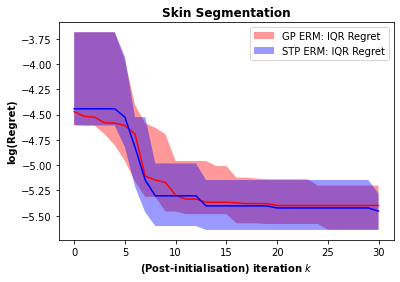

In [110]:
### Visualise!

title = 'Skin Segmentation'

plt.figure()

plt.plot(median_gp, color = 'Red')
plt.plot(median_stp, color = 'Blue')

xstar = np.arange(0, max_iter+1, step=1)
plt.fill_between(xstar, lower_gp, upper_gp, facecolor = 'Red', alpha=0.4, label='GP ERM: IQR Regret')
plt.fill_between(xstar, lower_stp, upper_stp, facecolor = 'Blue', alpha=0.4, label='STP ERM: IQR Regret')# r'($\nu$' ' = {})'.format(df))

plt.title(title, weight = 'bold')
plt.xlabel('(Post-initialisation) iteration $\it{k}$', weight = 'bold') # x-axis label
plt.ylabel('log(Regret)', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

plt.show() #visualise
